In [34]:
import json 
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle
import seaborn as sns
import pandas as pd

from epuc.datasets import (
    SineRegressionDataset,
    PolynomialDataset,
    polynomial_fct,
    sine_fct_prediction,
    BernoulliSineDataset
)
from epuc.helpers.ensemble import Ensemble, GaussianEnsemble, NIGEnsemble
from epuc.configs import model_config, data_config, create_train_config
from epuc.uncertainty import (
    get_upper_lower_bounds_normal,
    get_upper_lower_bounds_empirical,
    get_upper_lower_bounds_inv_gamma,
)
from epuc.helpers.plot_functions import plot_bernoulli_beta_prediction_intervals
#from experiments.run_experiments import create_data
from epuc.datasets import create_evaluation_data

plt.style.use("seaborn-v0_8-bright")
import json 
import os

### Plot results of second order optimisation experiments

In [99]:
CLASS_DICT_PATH = os.path.join("./results/classification/final_results/")
CLASS_DICT_PATH2 = os.path.join("./results/classification/final_results_2/")
REGRESSION_DICT_PATH = os.path.join("./results/regression/final_results/")
CLASS_DICT_500 = "./results/classification/new_exp_500_samples/"
CLASS_DICT_100 = "./results/classification/new_exp_100_samples/"
CLASS_DICT_LONGER = "./results/classification/exp_longer_run/"

REG_DICT_100 = "./results/regression/regression_100/"
REG_DICT_500 = "./results/regression/regression_500/"
REG_DICT_1000 = "./results/regression/regression_1000/"


### 1. Classification Case

In [36]:
# load results for each experiment
def load_results(path):
    with open(path, 'rb') as f:
        results = pickle.load(f)
    return results

results_bernoulli = load_results(os.path.join(CLASS_DICT_PATH, "results_Bernoulli.pkl"))
results_beta_outer = load_results(os.path.join(CLASS_DICT_PATH, "results_Beta_outer.pkl"))
results_beta_inner = load_results(os.path.join(CLASS_DICT_PATH, "results_Beta_inner.pkl"))
results_beta_outer_reg = load_results(os.path.join(CLASS_DICT_PATH2, "results_Beta_outer_reg.pkl"))
results_beta_inner_reg = load_results(os.path.join(CLASS_DICT_PATH2, "results_Beta_inner_reg.pkl"))

In [31]:
keys = ["Bernoulli", "Beta_outer", "Beta_outer_reg", "Beta_inner","Beta_inner_reg"]
results_dict = dict(zip(keys, [results_bernoulli, results_beta_outer, results_beta_outer_reg, results_beta_inner, results_beta_inner_reg]))

evaluation data:

In [185]:
# evaluation data
dataset, x_eval, y_eval, x_inst, y_targets = create_evaluation_data(data_config, problem_type="classification", data_type="sine", n_eval_points=1000)
# create dataframe with instance values and targets
df_train_data = pd.DataFrame({"x": x_inst, "y": y_targets})

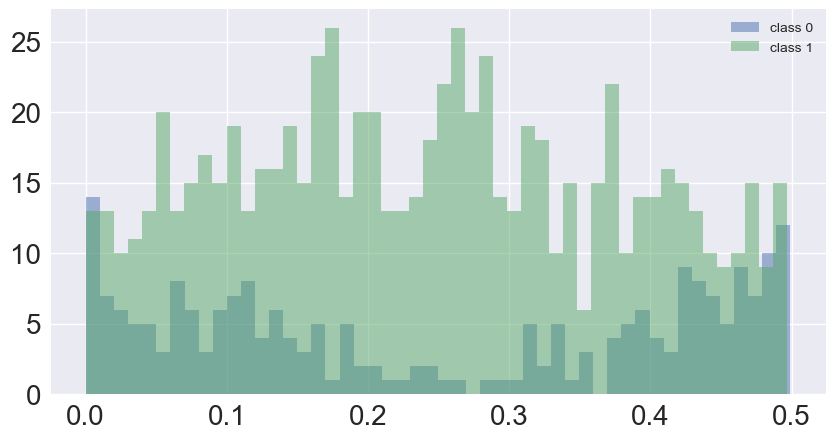

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(x_inst[y_targets==0], bins=50, alpha=0.5, label="class 0")
ax.hist(x_inst[y_targets==1], bins=50, alpha=0.5, label="class 1")
ax.legend()


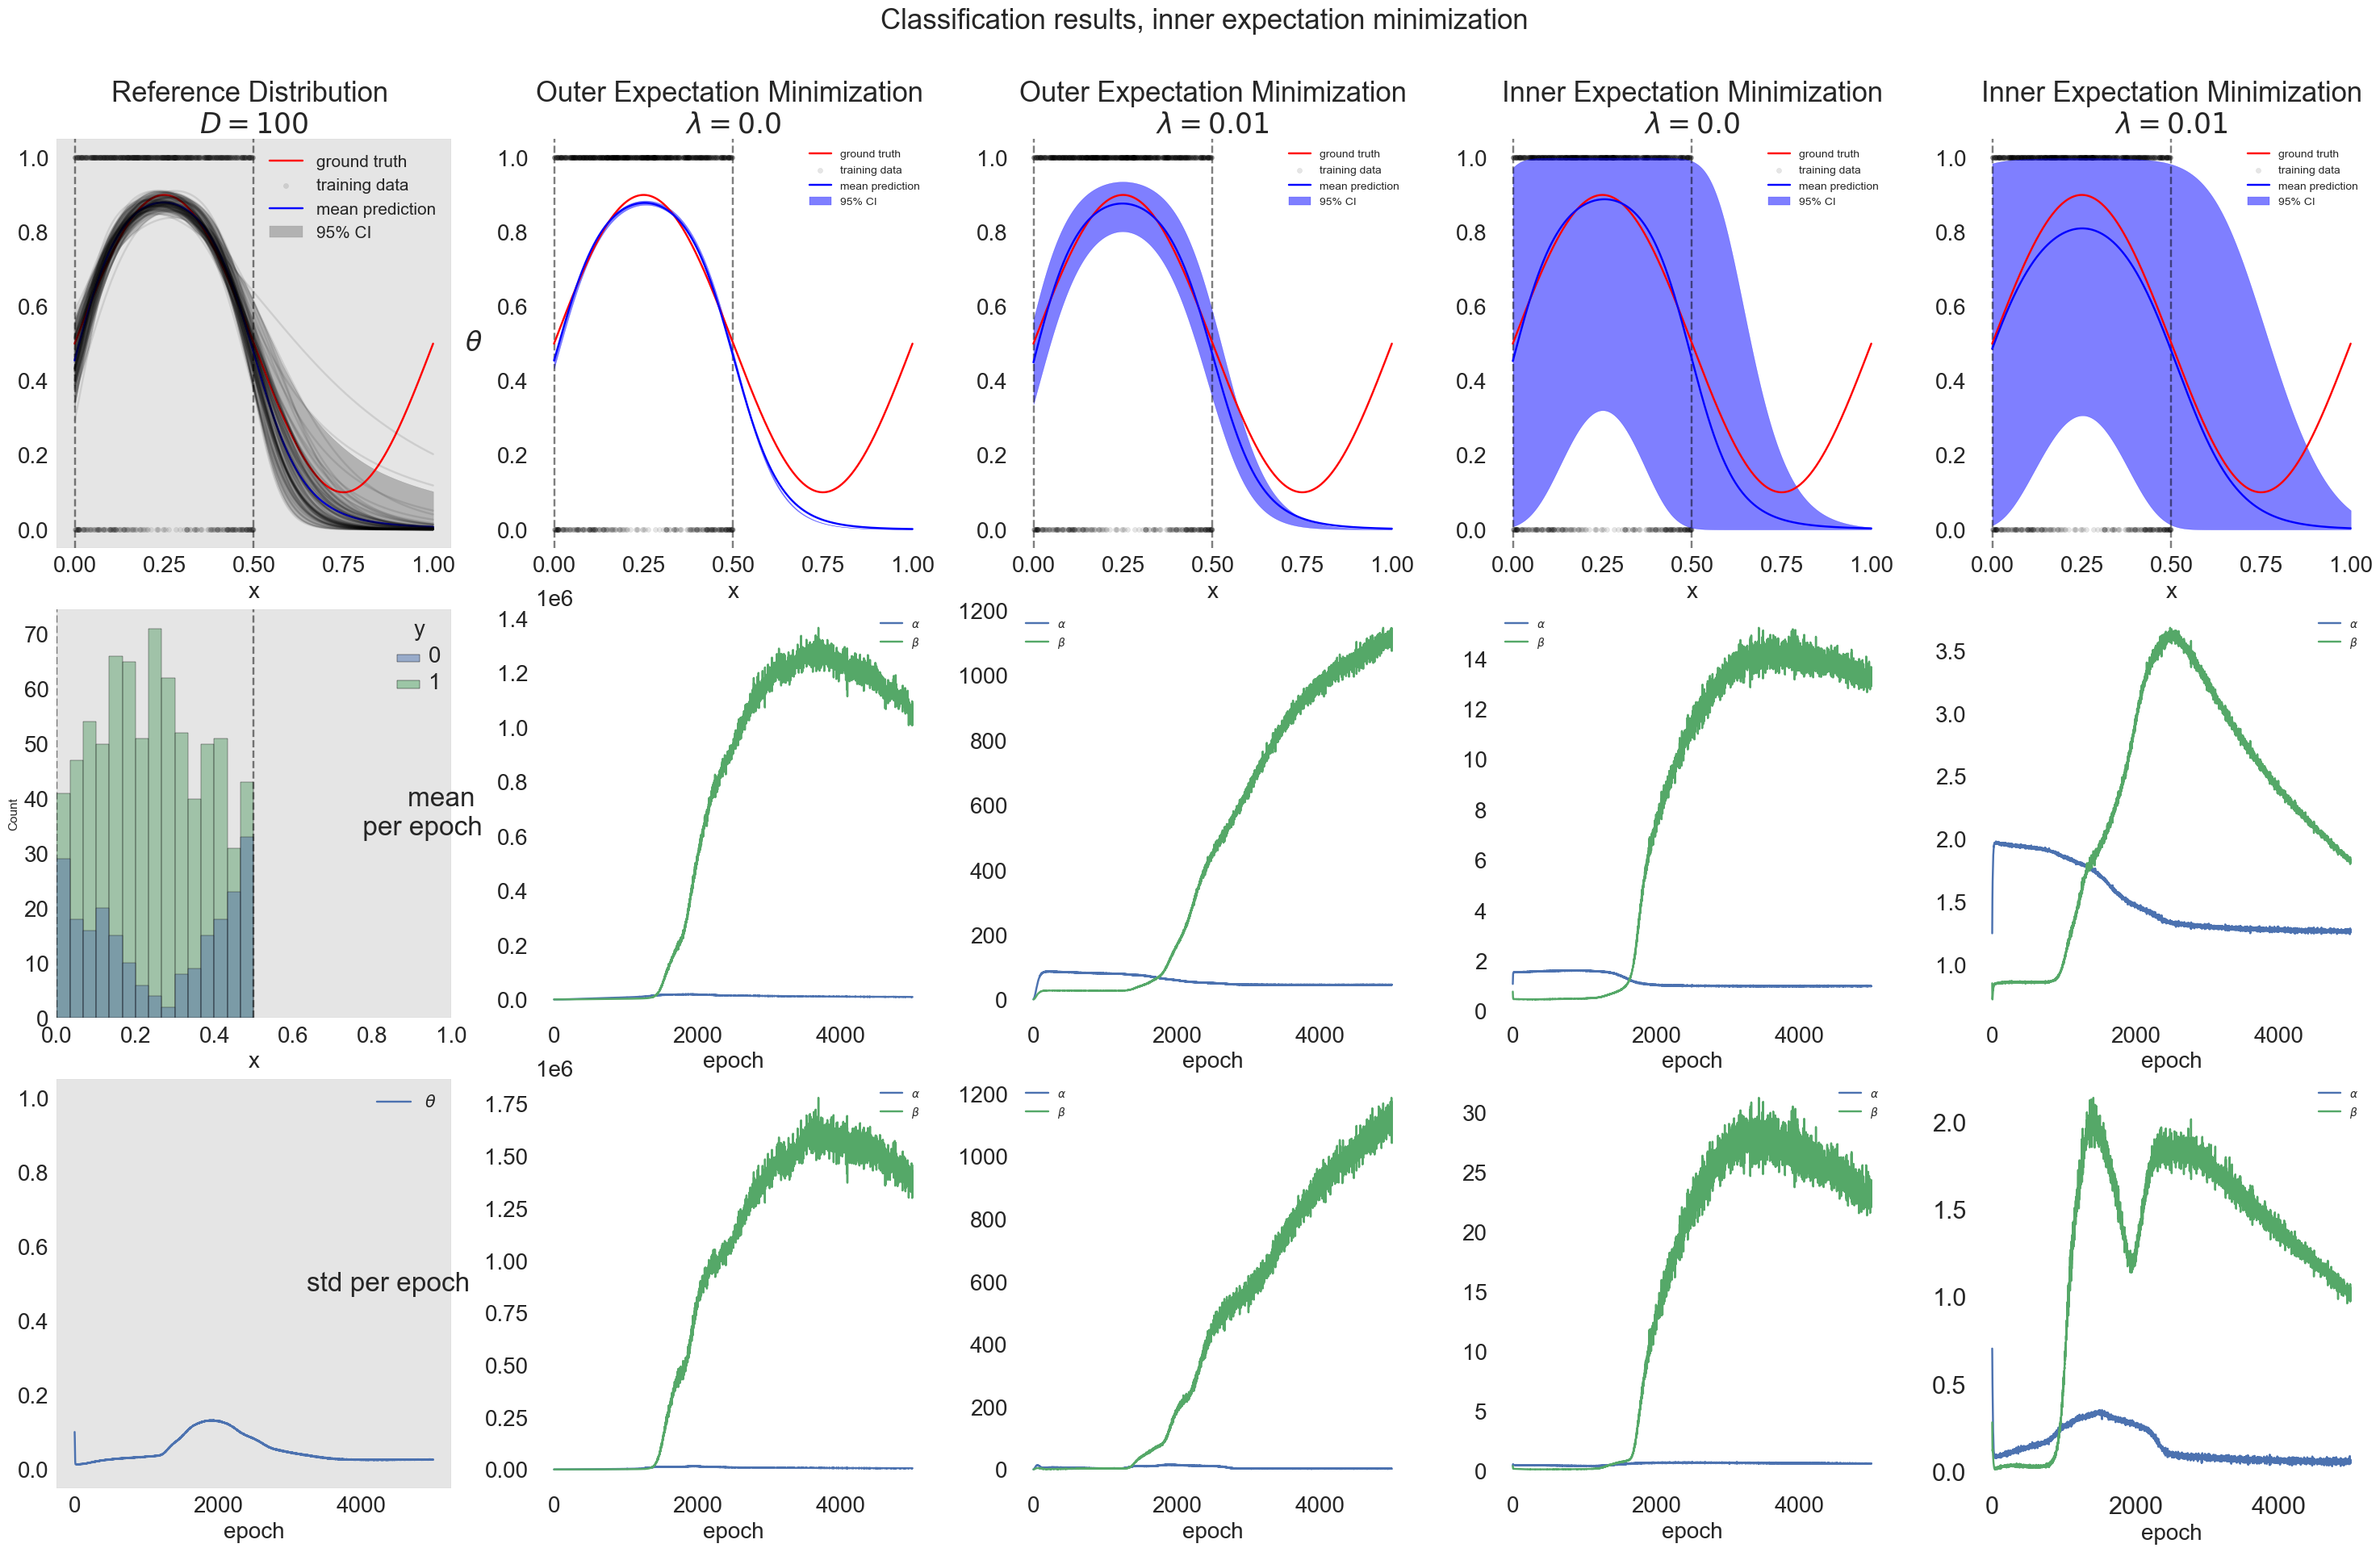

In [125]:
plt.rcParams['font.size'] = 20
import matplotlib

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

fig, ax = plt.subplots(3, len(results_dict), figsize=(30, 20))
plt.xticks(fontsize= 10)
for ax_row in ax:
    for ax_sub in ax_row:
        ax_sub.tick_params(axis='both', which='major', labelsize=12)
for axflat in ax.flat:
    axflat.tick_params(axis='both', which='major', labelsize=20)  # Change '10' to your desired size


plt.suptitle("Classification results, inner expectation minimization", fontsize=25)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plot 
# titles for rows 
#for ax_sub, col in zip(ax[0], ['reference distribution', 'Outer expectation minimization', r'entropy regularization, $\lambda = 1.0$']):
 #   ax_sub.set_title(col, fontsize=20)
# columns
for ax_sub, row in zip(ax[:,1], [r'$\theta$', 'mean \n per epoch', 'std per epoch']):
    ax_sub.annotate(row, xy=(0, 0.5), xytext=(-ax_sub.yaxis.labelpad - 5, 0),
                xycoords=ax_sub.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
# ----
    
for i in range(3):
    for j in range(len(results_dict)):
    #ax[i,0].set_facecolor("white")
        ax[i, j].set_facecolor("white")
for i, ens_type in enumerate(results_dict.keys()):
    

    ax[0, i].axvline(x_inst.min(), linestyle="--", color="black", alpha=0.5)
    ax[0, i].axvline(x_inst.max(), linestyle="--", color="black", alpha=0.5)
    
    ax[0, i].plot(x_eval, y_eval, label="ground truth", color="red")
    ax[0, i].set_xlabel("x", fontsize=20)
    ax[1, i].set_xlabel("epochs", fontsize=20)
    ax[2, i].set_xlabel("epochs", fontsize=20)
    # set y scale of second row to log
    #ax[1, i].set_yscale("log")
    #ax[0, i].set_yscale("log")

    ax[0, i].scatter(
            x_inst,
            y_targets,
            label="training data",
            marker="o",
            s=20,
            color="black",
            alpha=0.1,
        )

    if ens_type == "Bernoulli":
        # plot predictions for theta ------------------------------------
        ax[0, i].plot(
            x_eval,
            results_dict[ens_type]["mean_probs"],
            label="mean prediction",
            color="blue",
        )
        ax[0, i].plot(
            x_eval, results_dict[ens_type]["pred_probs"][:, :, 0], alpha=0.1, color="black"
        )
        ax[0, i].fill_between(
            x_eval,
            results_dict[ens_type]["lower_p"],
            results_dict[ens_type]["upper_p"],
            alpha=0.5,
            label="95% CI",
            color="gray",
        )
        ax[0, i].legend(fontsize=15)
        # --------------------------------------------
        # plot histograms of targets
        gfs = sns.histplot(df_train_data, x='x', hue='y', bins=15, ax=ax[1, i], alpha=0.5, legend=True)
        ax[1,i].set_xlim(0,1)
        ax[1,i].set_xlabel("x", fontsize=20)
       # ax[1,i].set_ylabel("probability", fontsize=20)
        ax[1, i].axvline(x_inst.min(), linestyle="--", color="black", alpha=0.5)
        ax[1, i].axvline(x_inst.max(), linestyle="--", color="black", alpha=0.5)
    
        plt.setp(gfs.get_legend().get_title(), fontsize='20') 
        plt.setp(gfs.get_legend().get_texts(), fontsize='20') 
        plt.setp(gfs.get_legend().get_texts()[0], fontsize='20')

        #ax[1, i].plot(x_eval, y_eval, label=r"$\theta$", color="red")

        #ax[1, i].hist(x_inst[y_targets == 0], bins=10, label="class 0", alpha=0.5)
        #ax[1, i].hist(x_inst[y_targets == 1], bins=10, label="class 1", alpha=0.5)
        # plot std
        ax[2, i].plot(results_dict[ens_type]["param_0_std"], label=r"$\theta$")
        ax[2, i].set_xlabel("epoch")
        ax[2, i].legend(fontsize=15)



    else:
        # plot predictions for mu ------------------------------------
        ax[0, i].plot(
            x_eval,
            results_dict[ens_type]["mean_pred_p"],
            label="mean prediction",
            color="blue",
        )
        ax[0, i].fill_between(
            x_eval,
            results_dict[ens_type]["lower_p"],
            results_dict[ens_type]["upper_p"],
            alpha=0.5,
            label="95% CI",
            color="blue",
        )
        
        ax[0, i].legend()
        # ------------------------------------
        ax[1, i].plot(results_dict[ens_type]["param_0"], label=r"$\alpha$")
        ax[1, i].plot(results_dict[ens_type]["param_1"], label=r"$\beta$")
        ax[1, i].set_xlabel("epoch")
        ax[1, i].legend()
        # std
        ax[2, i].plot(results_dict[ens_type]["param_0_std"], label=r"$\alpha$")
        ax[2, i].plot(results_dict[ens_type]["param_1_std"], label=r"$\beta$")
        ax[2, i].set_xlabel("epoch")
        ax[2, i].legend()
# ------------------------------------
        # titles 
ax[0, 0].set_title("Reference Distribution \n" + r"$D=100$", fontsize=25)
ax[0,1].set_title("Outer Expectation Minimization \n" + r"$\lambda=0.0$", fontsize=25)
ax[0,2].set_title("Outer Expectation Minimization\n" + r"$\lambda=0.01$", fontsize=25)
ax[0,3].set_title("Inner Expectation Minimization\n" + r"$\lambda=0.0$", fontsize=25)
ax[0,4].set_title("Inner Expectation Minimization\n" + r"$\lambda=0.01$", fontsize=25)

# add 
for i in range(3):  # 3 rows
    # Create a rectangle patch with the same size as the subplot
    rect = patches.Rectangle((0, 0), 1, 1, transform=ax[i, 0].transAxes, color='gray', alpha=0.2)

    # Add the rectangle patch to the subplot
    ax[i, 0].add_patch(rect)

plt.tick_params(axis='both', which='major', labelsize=22)
#ax[0, 1].set_subtitle("test")

### Show results for different number of training samples


load the data for the training with less samples:

In [98]:
# load data
results_bernoulli_500 = load_results(os.path.join(CLASS_DICT_500, "results_Bernoulli.pkl"))
results_beta_outer_500 = load_results(os.path.join(CLASS_DICT_500, "results_Beta_outer.pkl"))
results_beta_outer_reg_500 = load_results(os.path.join(CLASS_DICT_500, "results_Beta_outer_reg.pkl"))
results_beta_inner_500 = load_results(os.path.join(CLASS_DICT_500, "results_Beta_inner.pkl"))
results_beta_inner_reg_500 = load_results(os.path.join(CLASS_DICT_500, "results_Beta_inner_reg.pkl"))

results_dict_500 = dict(zip(keys, [results_bernoulli_500, results_beta_outer_500, results_beta_outer_reg_500, results_beta_inner_500, results_beta_inner_reg_500]))

results_bernoulli_100 = load_results(os.path.join(CLASS_DICT_100, "results_Bernoulli.pkl"))
results_beta_outer_100 = load_results(os.path.join(CLASS_DICT_100, "results_Beta_outer.pkl"))
results_beta_inner_100 = load_results(os.path.join(CLASS_DICT_100, "results_Beta_inner.pkl"))
results_beta_outer_reg_100 = load_results(os.path.join(CLASS_DICT_100, "results_Beta_outer_reg.pkl"))
results_beta_inner_reg_100 = load_results(os.path.join(CLASS_DICT_100, "results_Beta_inner_reg.pkl"))

results_dict_100 = dict(zip(keys, [results_bernoulli_100, results_beta_outer_100, results_beta_outer_reg_100, results_beta_inner_100, results_beta_inner_reg_100]))



In [8]:
results_dicts = [results_dict_100, results_dict_500, results_dict]

In [9]:
titles_rows = [r"$N=100$", r"$N=500$", r"$N=1000$"]
titles_cols = [
        "Reference Distribution \n",
        "Outer Expectation Minimization \n" + r"$\lambda=0.0$",
        "Outer Expectation Minimization \n" + r"$\lambda=0.01$",
        "Inner Expectation Minimization \n" + r"$\lambda=0.0$",
        "Inner Expectation Minimization \n" + r"$\lambda=0.01$",
    ]

In [10]:
results_dict['Beta_outer'].keys()

dict_keys(['param_0', 'param_1', 'param_0_std', 'param_1_std', 'pred_alphas', 'pred_betas', 'mean_pred_p', 'lower_p', 'upper_p'])

In [17]:
#sns.set_style("whitegrid")
def plot_confidence_bounds_per_experiment(
    list_results: list,
    dataset,
    list_train_points: list,
    list_row_titles: list,
    list_col_titles: list,
    figsize: tuple,
    save_path: str,
    file_name: str,
    **kwargs_data,
):
    fig, ax = plt.subplots(len(list_results), len(list_results[0]), figsize=figsize)
    # plt.xticks(fontsize= 10)
    for ax_row in ax:
        for ax_sub in ax_row:
            ax_sub.tick_params(axis="both", which="major", labelsize=12)
    for axflat in ax.flat:
        axflat.tick_params(axis="both", which="major", labelsize=20)

    # plt.suptitle("Classification results", fontsize=25)
    # adjust spacing between subplots
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    for i, title in enumerate(list_row_titles[::-1]):
        fig.text(
            0.1,
            (1.7 * i + 1) / 6,
            title,
            ha="center",
            va="center",
            rotation="vertical",
            fontsize=25,
        )
    # ax[0, 1].set_subtitle("test")
    for i, title in enumerate(list_col_titles):
        ax[0, i].set_title(title, fontsize=20)

    for i in range(3):
       for j in range(len(list_results[0])):
           pass
             #ax[i, j].set_facecolor("white")
    for i, ens_type in enumerate(list_results[0].keys()):
        for j, results_dict in enumerate(list_results):
            dataset_train = dataset(list_train_points[j], **kwargs_data)
            x_inst = dataset_train.x_inst
            y_targets = (
                dataset_train.y_targets
                if hasattr(dataset_train, "y_targets")
                else dataset_train.y_labels
            )
            x_eval = np.linspace(0, 1, 1000)
            y_eval = sine_fct_prediction(x_eval)

            # create dataframe with instance values and targets
            # plot vertical lines for where training data is
            ax[j, i].axvline(x_inst.min(), linestyle="--", color="black", alpha=0.5)
            ax[j, i].axvline(x_inst.max(), linestyle="--", color="black", alpha=0.5)
            # plot ground truth
            ax[j, i].plot(x_eval, y_eval, label=r"ground truth $\theta$", color="red")
            ax[j, i].set_xlabel("x", fontsize=20)
            # ax[j, i].set_ylabel(r"$\theta$", fontsize=20)

            # scatter training data
            ax[j, i].scatter(
                x_inst,
                y_targets,
                label="training data",
                marker="x",
                s=15,
                color="red",
                alpha=0.3,
            )
            # plot predictions for theta ------------------------------------
            if ens_type == "Bernoulli":
                ax[j, i].plot(
                    x_eval,
                    results_dict[ens_type]["mean_probs"],
                    label="mean prediction",
                    color="blue",
                )
                ax[j, i].plot(
                    x_eval,
                    results_dict[ens_type]["pred_probs"][:, :, 0],
                    alpha=0.1,
                    color="black",
                )
                ax[j, i].fill_between(
                    x_eval,
                    results_dict[ens_type]["lower_p"],
                    results_dict[ens_type]["upper_p"],
                    alpha=0.5,
                    label="95% CI",
                    color="gray",
                )
            else:
                # plot predictions for mu ------------------------------------
             #   ax[j, i].plot(
             #       x_eval,
             #       results_dict[ens_type]["mean_pred_p"],
             #       label="mean prediction",
             ##       color="blue",
             #   )
                mean_pred_p = results_dict[ens_type]["pred_alphas"].mean(axis=1) / (
                    results_dict[ens_type]["pred_alphas"].mean(axis=1)
                    + results_dict[ens_type]["pred_betas"].mean(axis=1)
                )
                ax[j, i].plot(
                    x_eval, mean_pred_p, label = "mean prediction", color="blue"
                )
                ax[j, i].fill_between(
                    x_eval,
                    results_dict[ens_type]["lower_p"],
                    results_dict[ens_type]["upper_p"],
                    alpha=0.5,
                    label="95% CI",
                    color="blue",
                )
            if j ==0 and i == 0:
                ax[j, i].legend(fontsize=15)
    # ------------------------------------
    # add
    for i in range(3):  # 3 rows
        # Create a rectangle patch with the same size as the subplot
        rect = patches.Rectangle(
            (0, 0), 1, 1, transform=ax[i, 0].transAxes, color="gray", alpha=0.2
        )

        # Add the rectangle patch to the subplot
        ax[i, 0].add_patch(rect)

    plt.tick_params(axis="both", which="major", labelsize=22)

    # save plot in results folder
    # make sure folder exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(
        save_path + file_name,
        bbox_inches="tight",
    )
    return fig, ax

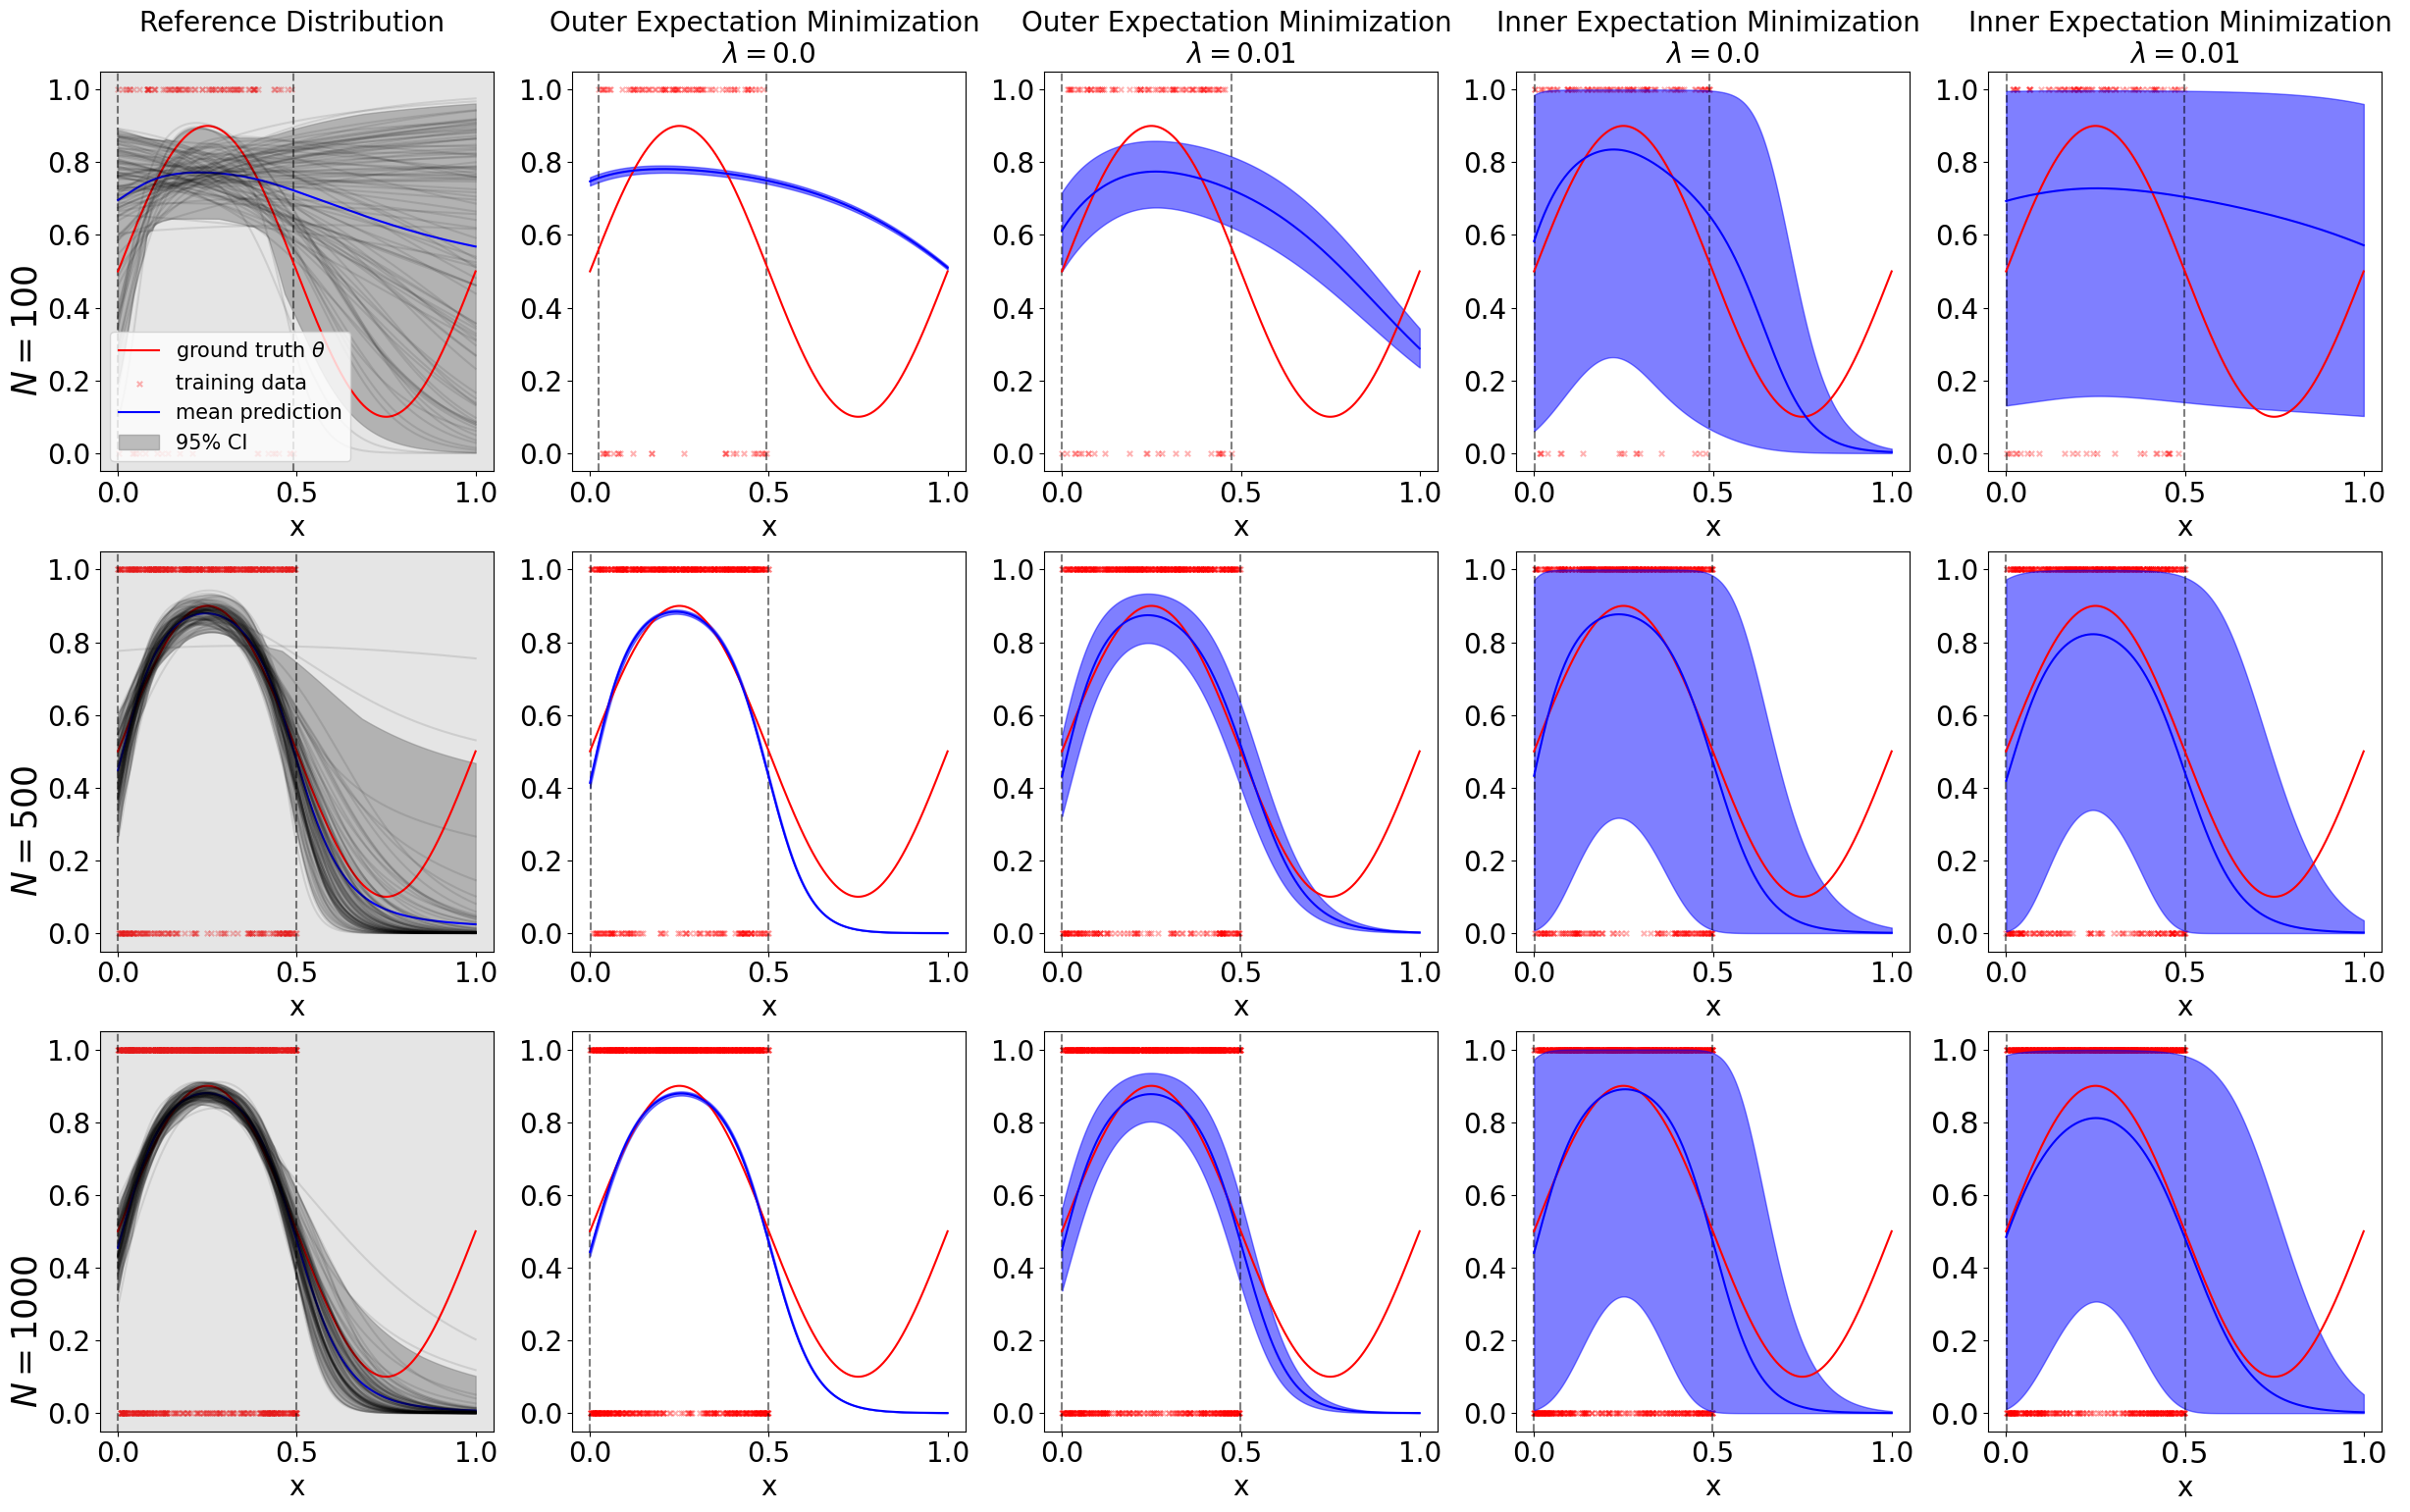

In [18]:
fig, ax = plot_confidence_bounds_per_experiment(results_dicts,BernoulliSineDataset, [100, 500, 1000], titles_rows, titles_cols, (30, 18), "./results/classification/", "conf_classification.pdf")

### plot divergence of parameters over time:

In [20]:
results_bernoulli_longer = load_results(os.path.join(CLASS_DICT_LONGER, "results_Bernoulli.pkl"))
results_beta_outer_longer = load_results(os.path.join(CLASS_DICT_LONGER, "results_Beta_outer.pkl"))
results_beta_inner_longer = load_results(os.path.join(CLASS_DICT_LONGER, "results_Beta_inner.pkl"))

In [21]:
results_bernoulli_longer.keys()

dict_keys(['param_0', 'param_0_std', 'mean_probs', 'pred_probs', 'lower_p', 'upper_p'])

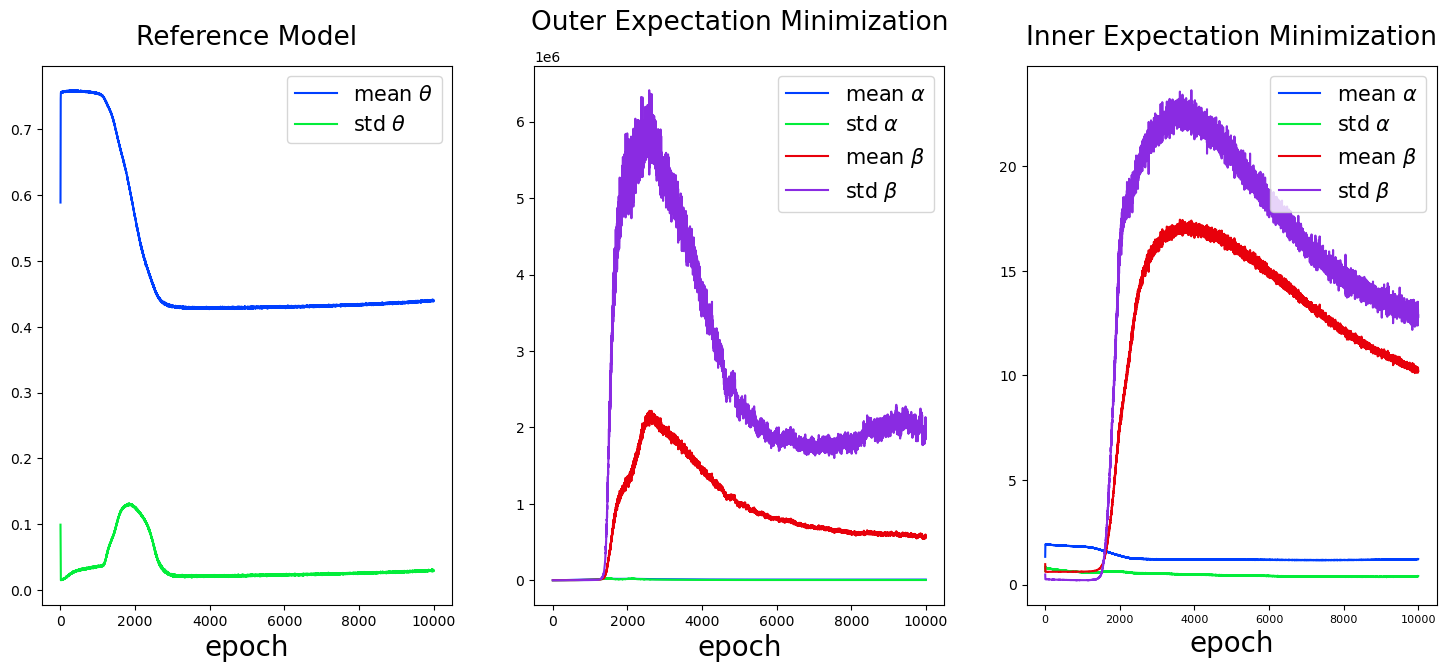

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(18, 7))
plt.xticks(fontsize= 8)
for axflat in ax.flat:
    axflat.tick_params(axis="both", which="major", labelsize=15)


# why are x ticks for last plot smaller? 
# make background white
for ax_sub in ax:
    ax_sub.set_facecolor("white")

col_titles = ["Reference Model", "Outer Expectation Minimization", "Inner Expectation Minimization"]
for ax_sub, col in zip(ax, col_titles):
    ax_sub.set_title(col, fontsize=19, pad=15)


# plot
ax[0].plot(results_bernoulli_longer["param_0"], label=r"mean $\theta$")
ax[0].plot(results_bernoulli_longer["param_0_std"], label=r"std $\theta$")

ax[0].set_xlabel("epoch", fontsize=20)
ax[0].legend(fontsize=15)  

ax[1].plot(results_beta_outer_longer["param_0"], label=r"mean $\alpha$")
ax[1].plot(results_beta_outer_longer["param_0_std"], label=r"std $\alpha$")
ax[1].plot(results_beta_outer_longer["param_1"], label=r"mean $\beta$")
ax[1].plot(results_beta_outer_longer["param_1_std"], label=r"std $\beta$")


ax[1].set_xlabel("epoch", fontsize=20)
ax[1].legend(fontsize=15)

ax[2].plot(results_beta_inner_longer["param_0"], label=r"mean $\alpha$")
ax[2].plot(results_beta_inner_longer["param_0_std"], label=r"std $\alpha$")
ax[2].plot(results_beta_inner_longer["param_1"], label=r"mean $\beta$")
ax[2].plot(results_beta_inner_longer["param_1_std"], label=r"std $\beta$")

ax[2].set_xlabel("epoch", fontsize=20)
ax[2].legend(fontsize=15)

# save plot
if not os.path.exists("./results/classification/figures"):
    os.makedirs("./results/classification/figures")
plt.savefig("./results/classification/figures/classification_results_longer_run.pdf", bbox_inches="tight")

# set x ticks for last plot


##### dummy plot for conf bounds

In [74]:
CLASS_DICT_PATH = os.path.join("./results/classification/dummy_plot_new/")
results_dummy_bernoulli = load_results(os.path.join(CLASS_DICT_PATH, "results_Bernoulli.pkl"))
results_dummy_beta_outer = load_results(os.path.join(CLASS_DICT_PATH, "results_Beta_outer.pkl"))
results_beta_inner = load_results(os.path.join(CLASS_DICT_PATH, "results_Beta_inner.pkl"))

In [75]:
results_dummy_bernoulli["conf_bounds"]["param_0"].keys()
n_epochs = results_dummy_bernoulli["conf_bounds"]["param_0"]["mean"].shape[0]

In [91]:
results_beta_inner.keys()

dict_keys(['conf_bounds', 'param_0_std', 'param_1_std', 'pred_alphas', 'pred_betas', 'mean_pred_p', 'lower_p', 'upper_p'])

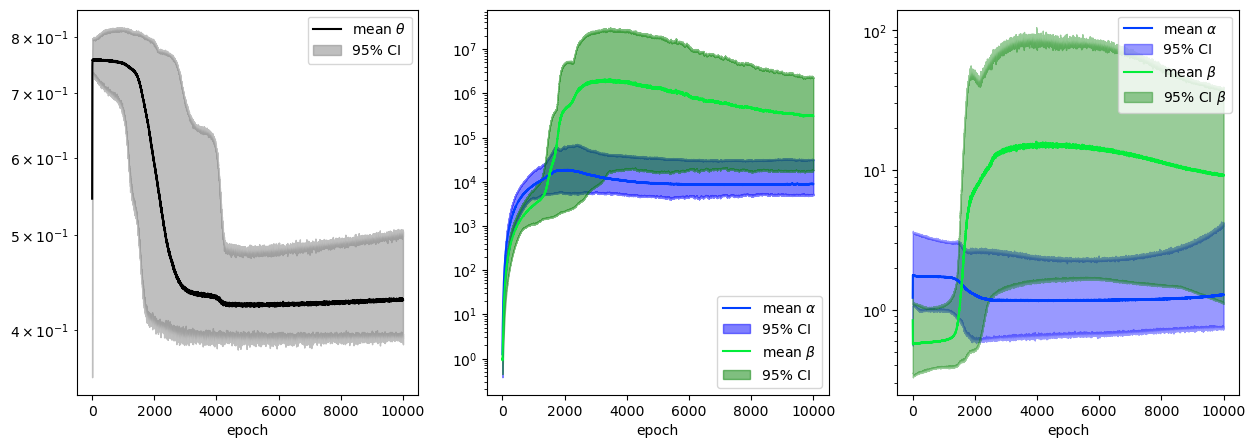

In [96]:

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(results_dummy_bernoulli["conf_bounds"]["param_0"]["mean"], color="black", label=r"mean $\theta$")
ax[0].fill_between(
    np.arange(0, n_epochs),
    results_dummy_bernoulli["conf_bounds"]["param_0"]["lower"],
    results_dummy_bernoulli["conf_bounds"]["param_0"]["upper"],
    alpha=0.5,
    label="95% CI",
    color="gray",
)
for i in range(3):
    ax[i].set_xlabel("epoch", fontsize=10)
ax[0].legend(fontsize=10)
# log scale y axis
ax[0].set_yscale("log")

ax[1].plot(results_dummy_beta_outer["conf_bounds"]["param_0"]["mean"], label=r"mean $\alpha$")
ax[1].fill_between(
    np.arange(0, n_epochs),
    results_dummy_beta_outer["conf_bounds"]["param_0"]["lower"],
    results_dummy_beta_outer["conf_bounds"]["param_0"]["upper"],
    alpha=0.5,
    label="95% CI",
    color="blue",
)
ax[1].plot(results_dummy_beta_outer["conf_bounds"]["param_1"]["mean"], label=r"mean $\beta$")
ax[1].fill_between(
    np.arange(0, n_epochs),
    results_dummy_beta_outer["conf_bounds"]["param_1"]["lower"],
    results_dummy_beta_outer["conf_bounds"]["param_1"]["upper"],
    alpha=0.5,
    label="95% CI",
    color="green",
)

# log scale y axis
ax[1].set_yscale("log")
ax[1].legend(fontsize=10)

ax[2].plot(results_beta_inner["conf_bounds"]["param_0"]["mean"], label=r"mean $\alpha$")
ax[2].fill_between(
    np.arange(0, n_epochs),
    results_beta_inner["conf_bounds"]["param_0"]["lower"],
    results_beta_inner["conf_bounds"]["param_0"]["upper"],
    alpha=0.4,
    label="95% CI",
    color="blue",
)
ax[2].plot(results_beta_inner["conf_bounds"]["param_1"]["mean"], label=r"mean $\beta$")
ax[2].fill_between(
    np.arange(0, n_epochs),
    results_beta_inner["conf_bounds"]["param_1"]["lower"],
    results_beta_inner["conf_bounds"]["param_1"]["upper"],
    alpha=0.4,
    label=r"95% CI $\beta$",
    color="green",
)

ax[2].legend(fontsize=10)
# log scale y axis
ax[2].set_yscale("log")


### 2. Regression Case

In [242]:
results_normal = load_results(os.path.join(REGRESSION_DICT_PATH, "results_Normal.pkl"))
results_nig_outer = load_results(os.path.join(REGRESSION_DICT_PATH, "results_NIG_outer.pkl"))
results_nig_outer_reg = load_results(os.path.join(REGRESSION_DICT_PATH, "results_NIG_outer_reg.pkl"))
results_nig_inner = load_results(os.path.join(REGRESSION_DICT_PATH, "results_NIG_inner.pkl"))
results_nig_inner_reg = load_results(os.path.join(REGRESSION_DICT_PATH, "results_NIG_inner_reg.pkl"))

In [243]:
keys = ["Normal", "NIG_outer", "NIG_outer_reg", "NIG_inner", "NIG_inner_reg"]
results_dict_reg = dict(zip(keys, [results_bernoulli_100, results_beta_outer_100, results_beta_outer_reg_100, results_beta_inner_100, results_beta_inner_reg_100]))



In [115]:
# evaluation data
dataset, x_eval, y_eval, x_inst, y_targets = create_evaluation_data(data_config, problem_type=type, data_type="sine", n_eval_points=1000)

In [124]:
results_per_ens_dict.keys()
list_keys_outer = ["Normal", "NIG_outer", "NIG_outer_reg"]
list_keys_inner = ["Normal", "NIG_inner", "NIG_inner_reg"]
list_class_outer = ["Bernoulli", "Beta_outer", "Beta_outer_reg"]
list_class_inner = ["Bernoulli", "Beta_inner", "Beta_inner_reg"]
results_dict_ens_reduced = {k: v for k, v in results_per_ens_dict.items() if k in list_class_inner}

#### evaluation data

### plot case for outer expectation minimization

rgression case:

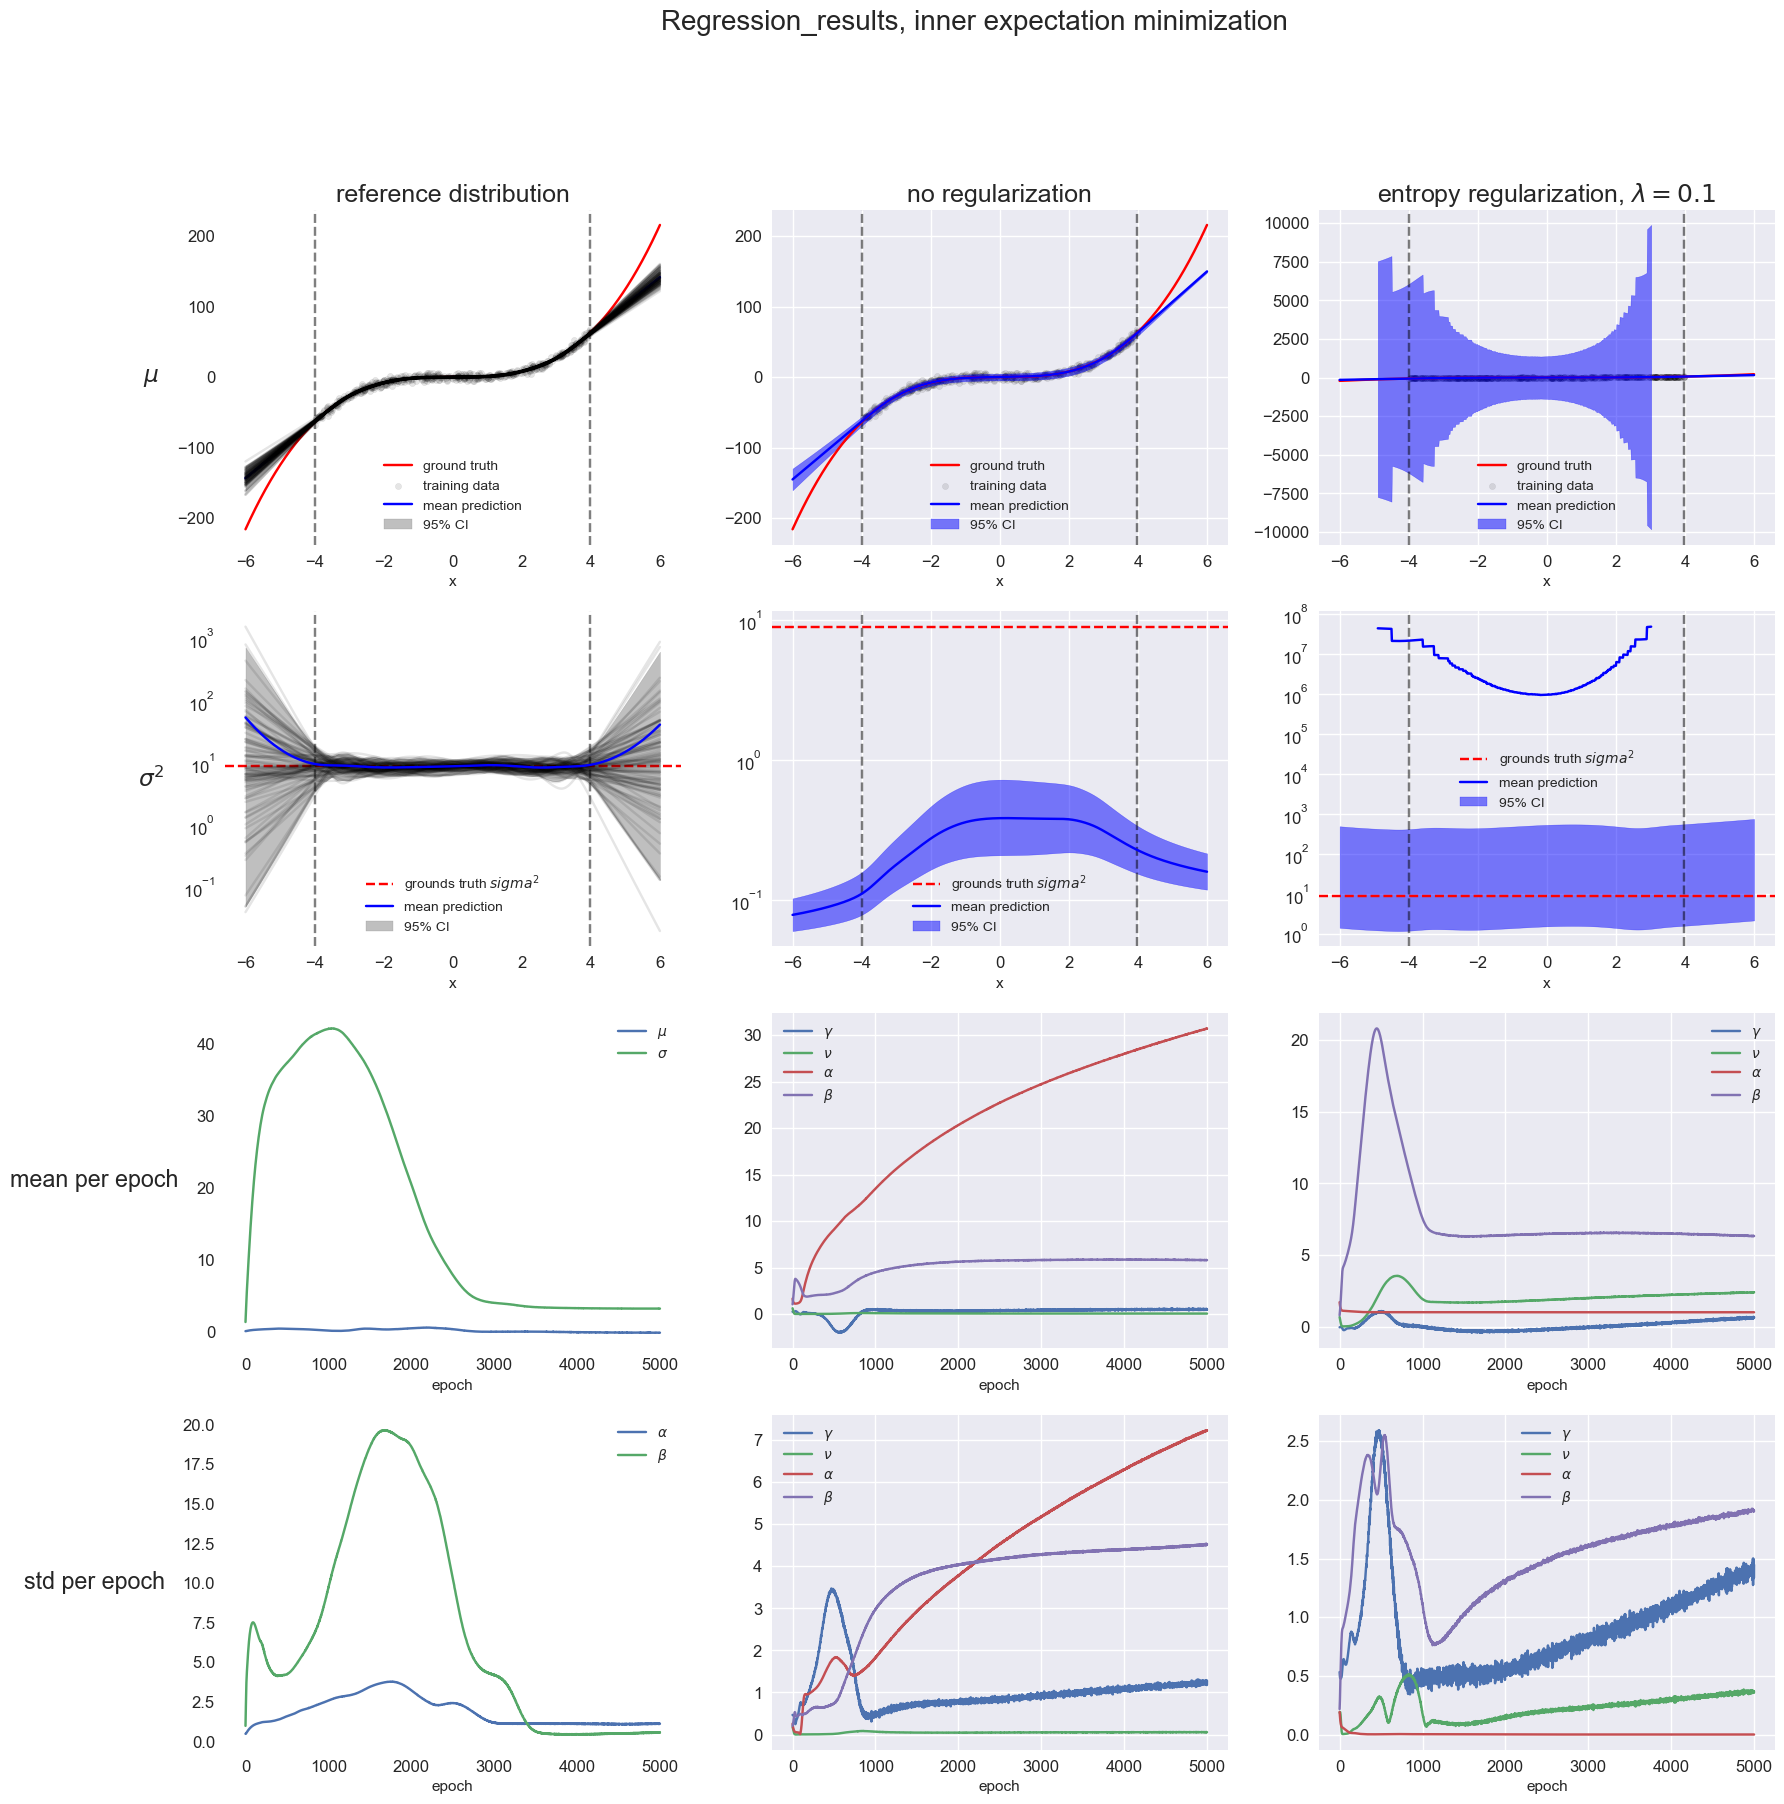

In [111]:
plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(4, len(results_dict_ens_reduced), figsize=(20, 20))
for ax_row in ax:
    for ax_sub in ax_row:
        ax_sub.tick_params(axis='both', which='major', labelsize=12)
plt.suptitle("Regression_results, inner expectation minimization", fontsize=20)
eps_std = 3
# plot 
# titles for rows 
for ax_sub, col in zip(ax[0], ['reference distribution', 'no regularization', r'entropy regularization, $\lambda = 0.1$']):
    ax_sub.set_title(col, fontsize=18)
# columns
for ax_sub, row in zip(ax[:,0], [r'$\mu$', r'$\sigma^2$', 'mean per epoch', 'std per epoch']):
    ax_sub.annotate(row, xy=(0, 0.5), xytext=(-ax_sub.yaxis.labelpad - 5, 0),
                xycoords=ax_sub.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
# ----
    
for i in range(4):
    ax[i,0].set_facecolor("white")
for i, ens_type in enumerate(results_dict_ens_reduced.keys()):
    

    ax[0, i].axvline(x_inst.min(), linestyle="--", color="black", alpha=0.5)
    ax[0, i].axvline(x_inst.max(), linestyle="--", color="black", alpha=0.5)
    ax[1, i].axvline(x_inst.min(), linestyle="--", color="black", alpha=0.5)
    ax[1, i].axvline(x_inst.max(), linestyle="--", color="black", alpha=0.5)
    
    ax[0, i].plot(x_eval, y_eval, label="ground truth", color="red")
    # plot horizontal line at eps_std **2
    ax[1, i].axhline(
        eps_std**2, linestyle="--", color="red", label="grounds truth $sigma^2$"
    )
    ax[0, i].set_xlabel("x")
    ax[1, i].set_xlabel("x")
    ax[2, i].set_xlabel("epochs")
    # set y scale of second row to log
    ax[1, i].set_yscale("log")
    #ax[0, i].set_yscale("log")

    ax[0, i].scatter(
            x_inst,
            y_targets,
            label="training data",
            marker="o",
            s=20,
            color="black",
            alpha=0.1,
        )

    if ens_type == "Normal":
        # plot predictions for mu ------------------------------------
        ax[0, i].plot(
            x_eval,
            results_dict_ens_reduced[ens_type]["mean_mus"],
            label="mean prediction",
            color="blue",
        )
        ax[0, i].plot(
            x_eval, results_dict_ens_reduced[ens_type]["pred_mus"], alpha=0.1, color="black"
        )
        ax[0, i].fill_between(
            x_eval,
            results_dict_ens_reduced[ens_type]["lower_mu"],
            results_dict_ens_reduced[ens_type]["upper_mu"],
            alpha=0.5,
            label="95% CI",
            color="gray",
        )
        ax[0, i].legend()
        # ------------------------------------
        # plot predictions for sigma
        ax[1, i].plot(
            x_eval,
            results_dict_ens_reduced[ens_type]["pred_sigmas2"],
            alpha=0.1,
            color="black",
        )
        ax[1, i].plot(
            x_eval,
            results_dict_ens_reduced[ens_type]["mean_sigma2"],
            label="mean prediction",
            color="blue",
        )
        ax[1, i].fill_between(
            x_eval,
            results_dict_ens_reduced[ens_type]["lower_sigma"],
            results_dict_ens_reduced[ens_type]["upper_sigma"],
            alpha=0.5,
            label="95% CI",
            color="gray",
        )
        ax[1, i].legend()
        # ------------------------------------
        # plot mean of predicted parameters
        ax[2, i].plot(results_dict_ens_reduced[ens_type]["param_0"], label=r"$\mu$")
        ax[2, i].plot(results_dict_ens_reduced[ens_type]["param_1"], label=r"$\sigma$")
        ax[2, i].set_xlabel("epoch")
        ax[2, i].legend()
        # plot std
        ax[3, i].plot(results_dict_ens_reduced[ens_type]["param_0_std"], label=r"$\alpha$")
        ax[3, i].plot(results_dict_ens_reduced[ens_type]["param_1_std"], label=r"$\beta$")
        ax[3, i].set_xlabel("epoch")
        ax[3, i].legend()



    else:
        # plot predictions for mu ------------------------------------
        ax[0, i].plot(
            x_eval,
            results_dict_ens_reduced[ens_type]["mean_pred_mu"],
            label="mean prediction",
            color="blue",
        )
        ax[0, i].fill_between(
            x_eval,
            results_dict_ens_reduced[ens_type]["lower_mu"],
            results_dict_ens_reduced[ens_type]["upper_mu"],
            alpha=0.5,
            label="95% CI",
            color="blue",
        )
        
        ax[0, i].legend()
        # ------------------------------------
        # plot predictions for sigma ------------------------------------
        ax[1, i].plot(
            x_eval,
            results_dict_ens_reduced[ens_type]["mean_pred_sigma2"],
            label="mean prediction",
            color="blue",
        )
        ax[1, i].fill_between(
            x_eval,
            results_dict_ens_reduced[ens_type]["lower_sigma"],
            results_dict_ens_reduced[ens_type]["upper_sigma"],
            alpha=0.5,
            label="95% CI",
            color="blue",
        )
        ax[1, i].legend()
        # ------------------------------------
        ax[2, i].plot(results_dict_ens_reduced[ens_type]["param_0"], label=r"$\gamma$")
        ax[2, i].plot(results_dict_ens_reduced[ens_type]["param_1"], label=r"$\nu$")
        ax[2, i].plot(results_dict_ens_reduced[ens_type]["param_2"], label=r"$\alpha$")
        ax[2, i].plot(results_dict_ens_reduced[ens_type]["param_3"], label=r"$\beta$")
        ax[2, i].set_xlabel("epoch")
        ax[2, i].legend()
        # std
        ax[3, i].plot(results_dict_ens_reduced[ens_type]["param_0_std"], label=r"$\gamma$")
        ax[3, i].plot(results_dict_ens_reduced[ens_type]["param_1_std"], label=r"$\nu$")
        ax[3, i].plot(results_dict_ens_reduced[ens_type]["param_2_std"], label=r"$\alpha$")
        ax[3, i].plot(results_dict_ens_reduced[ens_type]["param_3_std"], label=r"$\beta$")
        ax[3, i].set_xlabel("epoch")
        ax[3, i].legend()
        #
plt.savefig("./results/regression/2024-01-19/inner_expectation_minimization.pdf", bbox_inches='tight')

classification case:

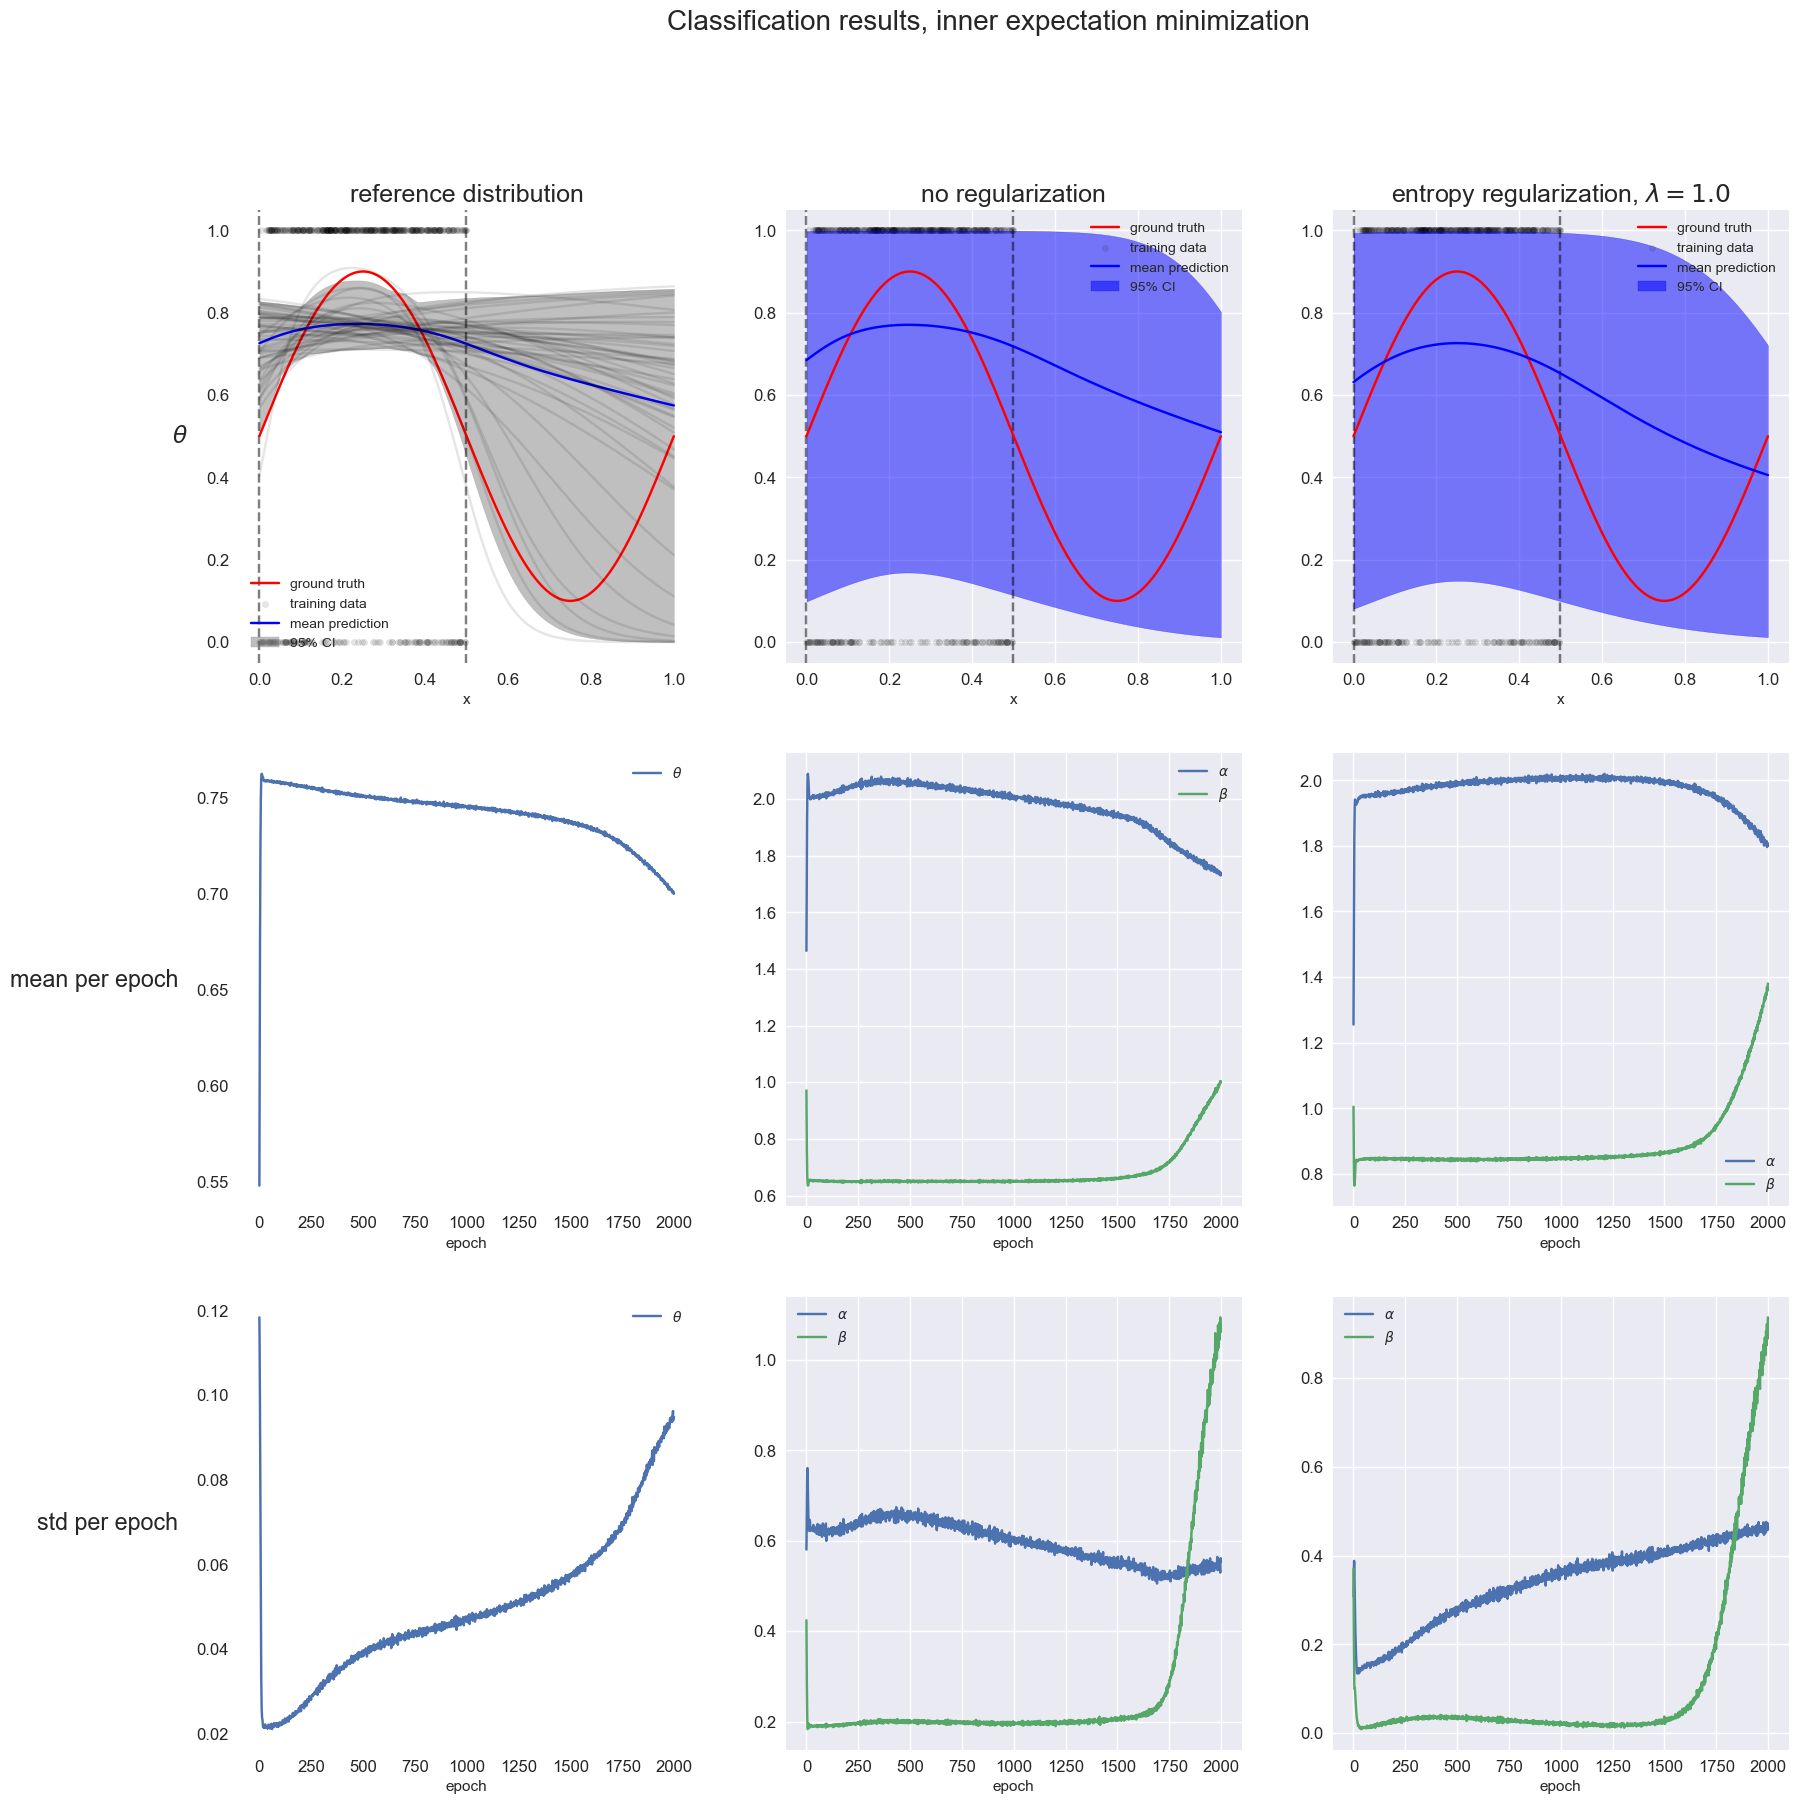

In [127]:
plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(3, len(results_dict_ens_reduced), figsize=(20, 20))
for ax_row in ax:
    for ax_sub in ax_row:
        ax_sub.tick_params(axis='both', which='major', labelsize=12)
plt.suptitle("Classification results, inner expectation minimization", fontsize=20)
eps_std = 3
# plot 
# titles for rows 
for ax_sub, col in zip(ax[0], ['reference distribution', 'no regularization', r'entropy regularization, $\lambda = 1.0$']):
    ax_sub.set_title(col, fontsize=18)
# columns
for ax_sub, row in zip(ax[:,0], [r'$\theta$', 'mean per epoch', 'std per epoch']):
    ax_sub.annotate(row, xy=(0, 0.5), xytext=(-ax_sub.yaxis.labelpad - 5, 0),
                xycoords=ax_sub.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
# ----
    
for i in range(3):
    ax[i,0].set_facecolor("white")
for i, ens_type in enumerate(results_dict_ens_reduced.keys()):
    

    ax[0, i].axvline(x_inst.min(), linestyle="--", color="black", alpha=0.5)
    ax[0, i].axvline(x_inst.max(), linestyle="--", color="black", alpha=0.5)
    
    ax[0, i].plot(x_eval, y_eval, label="ground truth", color="red")
    ax[0, i].set_xlabel("x")
    ax[1, i].set_xlabel("epochs")
    ax[2, i].set_xlabel("epochs")
    # set y scale of second row to log
    #ax[1, i].set_yscale("log")
    #ax[0, i].set_yscale("log")

    ax[0, i].scatter(
            x_inst,
            y_targets,
            label="training data",
            marker="o",
            s=20,
            color="black",
            alpha=0.1,
        )

    if ens_type == "Bernoulli":
        # plot predictions for theta ------------------------------------
        ax[0, i].plot(
            x_eval,
            results_dict_ens_reduced[ens_type]["mean_probs"],
            label="mean prediction",
            color="blue",
        )
        ax[0, i].plot(
            x_eval, results_dict_ens_reduced[ens_type]["pred_probs"][:, :, 0], alpha=0.1, color="black"
        )
        ax[0, i].fill_between(
            x_eval,
            results_dict_ens_reduced[ens_type]["lower_p"],
            results_dict_ens_reduced[ens_type]["upper_p"],
            alpha=0.5,
            label="95% CI",
            color="gray",
        )
        ax[0, i].legend()
        # --------------------------------------------
        # plot mean of predicted parameters
        ax[1, i].plot(results_dict_ens_reduced[ens_type]["param_0"], label=r"$\theta$")
        ax[1, i].set_xlabel("epoch")
        ax[1, i].legend()
        # plot std
        ax[2, i].plot(results_dict_ens_reduced[ens_type]["param_0_std"], label=r"$\theta$")
        ax[2, i].set_xlabel("epoch")
        ax[2, i].legend()



    else:
        # plot predictions for mu ------------------------------------
        ax[0, i].plot(
            x_eval,
            results_dict_ens_reduced[ens_type]["mean_pred_p"],
            label="mean prediction",
            color="blue",
        )
        ax[0, i].fill_between(
            x_eval,
            results_dict_ens_reduced[ens_type]["lower_p"],
            results_dict_ens_reduced[ens_type]["upper_p"],
            alpha=0.5,
            label="95% CI",
            color="blue",
        )
        
        ax[0, i].legend()
        # ------------------------------------
        ax[1, i].plot(results_dict_ens_reduced[ens_type]["param_0"], label=r"$\alpha$")
        ax[1, i].plot(results_dict_ens_reduced[ens_type]["param_1"], label=r"$\beta$")
        ax[1, i].set_xlabel("epoch")
        ax[1, i].legend()
        # std
        ax[2, i].plot(results_dict_ens_reduced[ens_type]["param_0_std"], label=r"$\alpha$")
        ax[2, i].plot(results_dict_ens_reduced[ens_type]["param_1_std"], label=r"$\beta$")
        ax[2, i].set_xlabel("epoch")
        ax[2, i].legend()
    
#plt.savefig("./results/classification/'2024-01-19-07-42-54'/outer_expectation_minimization.pdf", bbox_inches='tight')

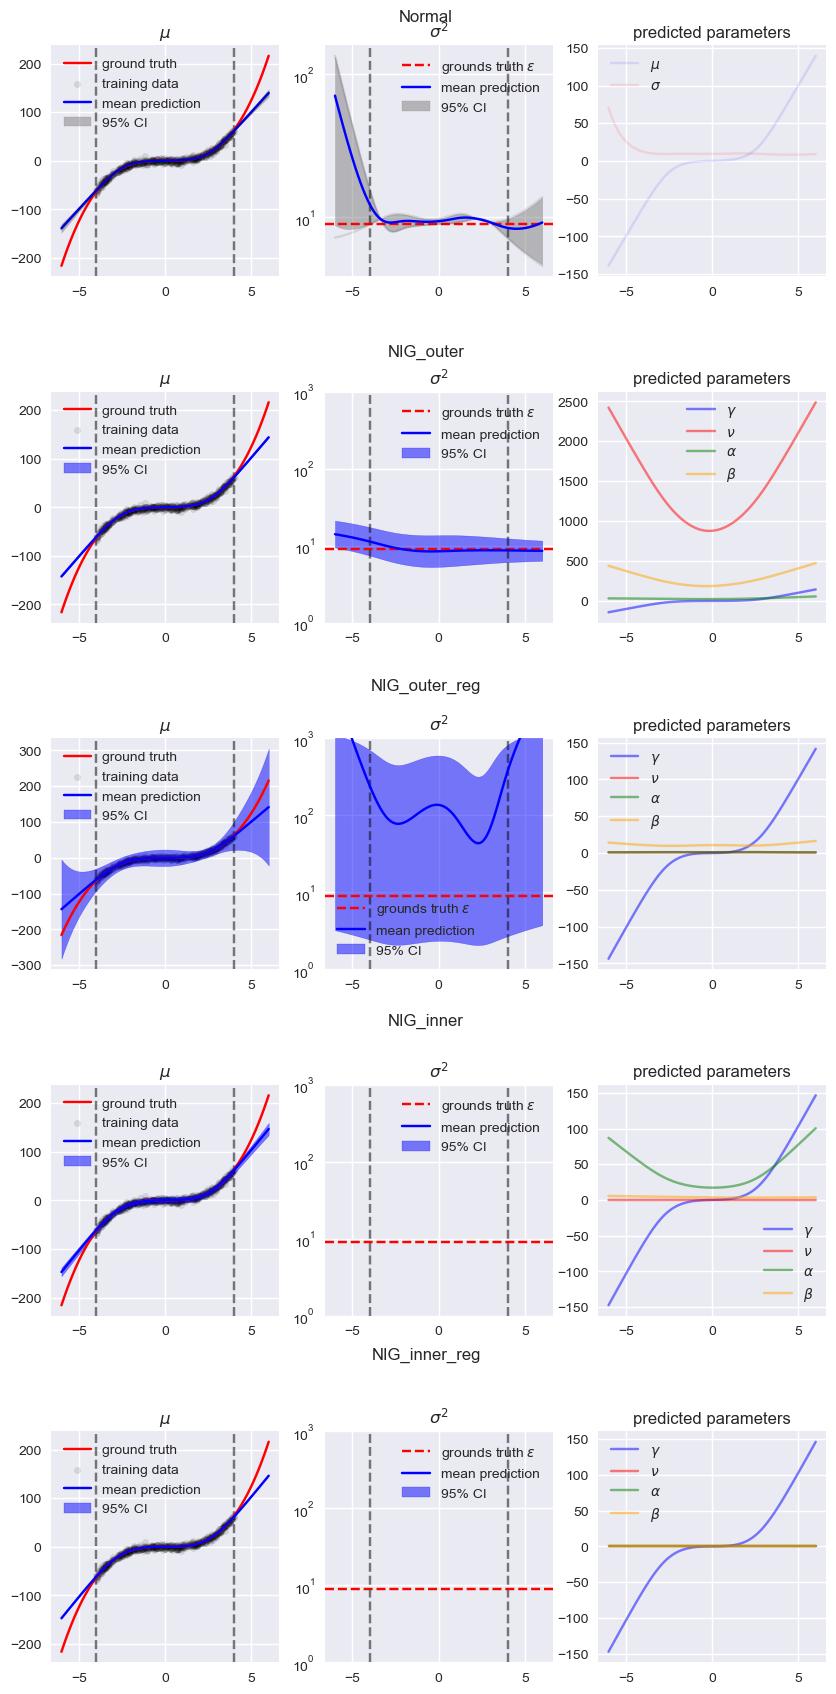

In [19]:
std = 3

fig, ax = plt.subplots(len(results_per_ens_dict), 3, figsize=(10, 21))
for i, ens_type in enumerate(results_per_ens_dict.keys()):
    fig.text(
        0.5,
        ax[i, 0].get_position().bounds[1] + ax[i, 0].get_position().height + 0.01,
        f"{ens_type}",
        ha="center",
        va="bottom",
        fontsize="large",
    )
    # plot dotted vertical lines for minimum and maximum of training data
    ax[i, 0].axvline(x_inst.min(), linestyle="--", color="black", alpha=0.5)
    ax[i, 0].axvline(x_inst.max(), linestyle="--", color="black", alpha=0.5)
    ax[i, 1].axvline(x_inst.min(), linestyle="--", color="black", alpha=0.5)
    ax[i, 1].axvline(x_inst.max(), linestyle="--", color="black", alpha=0.5)
    ax[i, 0].set_title("$\mu$")
    ax[i, 1].set_title("$\sigma^2$")
    ax[i, 2].set_title("predicted parameters")
    ax[i, 0].plot()
    ax[i, 0].plot(x_eval, y_eval, label="ground truth", color="red")
    # plot horizontal dotted line at std**3
    ax[i, 1].axhline(std**2, linestyle="--", color="red", label="grounds truth $\epsilon$")
    # plot training data
    ax[i, 0].scatter(
            x_inst,
            y_targets,
            label="training data",
            marker="o",
            s=20,
            color="black",
            alpha=0.1,
        )
    if ens_type == "Normal":
        # plot predictions for mu ------------------------------------
        ax[i, 0].plot(
            x_eval.squeeze(),
            results_per_ens_dict[ens_type]["mean_mus"],
            label="mean prediction",
            color="blue",
        )
        ax[i, 0].plot(
            x_eval, results_per_ens_dict[ens_type]["pred_mus"], alpha=0.1, color="black"
        )
        ax[i, 0].fill_between(
            x_eval,
            results_per_ens_dict[ens_type]["lower_mu"],
            results_per_ens_dict[ens_type]["upper_mu"],
            alpha=0.5,
            label="95% CI",
            color="gray",
        )
        ax[i, 0].legend()
        # ------------------------------------
        # plot predictions for sigma
        ax[i, 1].plot(
            x_eval.squeeze(),
            results_per_ens_dict[ens_type]["pred_sigmas2"],
            alpha=0.1,
            color="black",
        )
        ax[i, 1].plot(
            x_eval,
            np.mean((results_per_ens_dict[ens_type]["pred_sigmas2"]), axis=1),
            label="mean prediction",
            color="blue",
        )
        ax[i, 1].fill_between(
            x_eval,
            results_per_ens_dict[ens_type]["lower_sigma"],
            results_per_ens_dict[ens_type]["upper_sigma"],
            alpha=0.5,
            label="95% CI",
            color="gray",
        )
        ax[i, 1].legend()
        # set y scale to log
        ax[i, 1].set_yscale("log")
        # ------------------------------------
        # lpot predicted parameters of the normal distribution
        ax[i, 2].plot(
            x_eval,
            results_per_ens_dict[ens_type]["mean_mus"],            alpha=0.1,
            color="blue", label="$\mu$",
        )
        ax[i, 2].plot(
            x_eval,
            np.mean(results_per_ens_dict[ens_type]["pred_sigmas2"], axis=1),
            alpha=0.1,
            color="red", label="$\sigma$",
        )
        ax[i,2].legend()

    else:
        # plot predictions for mu ------------------------------------
        ax[i, 0].plot(
            x_eval.squeeze(),
            results_per_ens_dict[ens_type]["mean_pred_mu"],
            label="mean prediction",
            color="blue",
        )
        ax[i, 0].fill_between(
            x_eval,
            results_per_ens_dict[ens_type]["lower_mu"],
            results_per_ens_dict[ens_type]["upper_mu"],
            alpha=0.5,
            label="95% CI",
            color="blue",
        )
        
        ax[i, 0].legend()
        # ------------------------------------
        # plot predictions for sigma ------------------------------------
        ax[i, 1].plot(
            x_eval,
            results_per_ens_dict[ens_type]["mean_pred_sigma2"],
            label="mean prediction", color="blue",
        )
        ax[i, 1].fill_between(
            x_eval,
            results_per_ens_dict[ens_type]["lower_sigma"],
            results_per_ens_dict[ens_type]["upper_sigma"],
            alpha=0.5,
            label="95% CI",
            color="blue",
        )
        ax[i, 1].legend()
        # set y scale to log
        ax[i, 1].set_yscale("log")
        # set y range
        ax[i, 1].set_ylim(1, 1000)

        # ------------------------------------
        # plot predicted parameters of the normal-inverse-gamma distribution
        ax[i, 2].plot(
            x_eval,
            np.mean(results_per_ens_dict[ens_type]["pred_gammas"], axis=1),
            alpha=0.5,
            color="blue", label=r"$\gamma$",
        )
        ax[i, 2].plot(
            x_eval,
            np.mean(results_per_ens_dict[ens_type]["pred_nus"], axis=1),
            alpha=0.5,
            color="red", label=r"$\nu$",
        )
        ax[i, 2].plot(
            x_eval,
            np.mean(results_per_ens_dict[ens_type]["pred_alphas"], axis=1),
            alpha=0.5,
            color="green", label=r"$\alpha$",
        )
        ax[i, 2].plot(
            x_eval,
            np.mean(results_per_ens_dict[ens_type]["pred_betas"], axis=1),
            alpha=0.5,
            color="orange", label=r"$\beta$",
        )

        ax[i, 2].legend()
        

fig.subplots_adjust(hspace=0.5)


In [21]:
loaded_dict['Beta_outer']

{'param_0': tensor([ 1.5880,  1.8268,  2.0671,  2.3038,  2.5371,  2.7722,  3.0118,  3.2783,
          3.5458,  3.8391,  4.1328,  4.4300,  4.7237,  5.0081,  5.3071,  5.6139,
          5.9250,  6.2639,  6.6039,  6.9473,  7.2691,  7.5937,  7.9006,  8.2673,
          8.6478,  9.0237,  9.3551,  9.6814, 10.0633, 10.4230, 10.8597, 11.2338,
         11.5993, 11.9299, 12.2864, 12.6521, 12.9911, 13.4021, 13.7663, 14.2114,
         14.6273, 15.0953, 15.5092, 15.8161, 16.0621, 16.4974, 16.9489, 17.4303,
         17.8633, 18.1992]),
 'param_1': tensor([0.9675, 0.9003, 0.9037, 0.9569, 1.0425, 1.1427, 1.2522, 1.3482, 1.4516,
         1.5376, 1.6311, 1.7256, 1.8325, 1.9513, 2.0633, 2.1847, 2.3021, 2.4102,
         2.5206, 2.6261, 2.7576, 2.8992, 3.0580, 3.1771, 3.2929, 3.4120, 3.5629,
         3.7339, 3.8755, 4.0205, 4.1230, 4.2735, 4.4299, 4.6210, 4.7850, 4.9582,
         5.1627, 5.3129, 5.4940, 5.6273, 5.7856, 5.9236, 6.0974, 6.3226, 6.6019,
         6.7673, 6.9329, 7.0691, 7.2501, 7.4963]),
 'pred_

In [52]:
def plot_mean_params(loaded_dict):
    fig, ax = plt.subplots(len(loaded_dict), figsize=(5, 15))
    for i, key in enumerate(loaded_dict.keys()):
        if key == "Bernoulli":
            ax[i].plot(loaded_dict[key]["param_0"], label=r"$\theta$")
        else:
            ax[i].plot(loaded_dict[key]["param_0"], label=r"$\alpha$")
            ax[i].plot(loaded_dict[key]["param_1"], label=r"$\beta$")
        ax[i].set_title(key)
        ax[i].legend()
        ax[i].set_xlabel("epoch")
    plt.show()

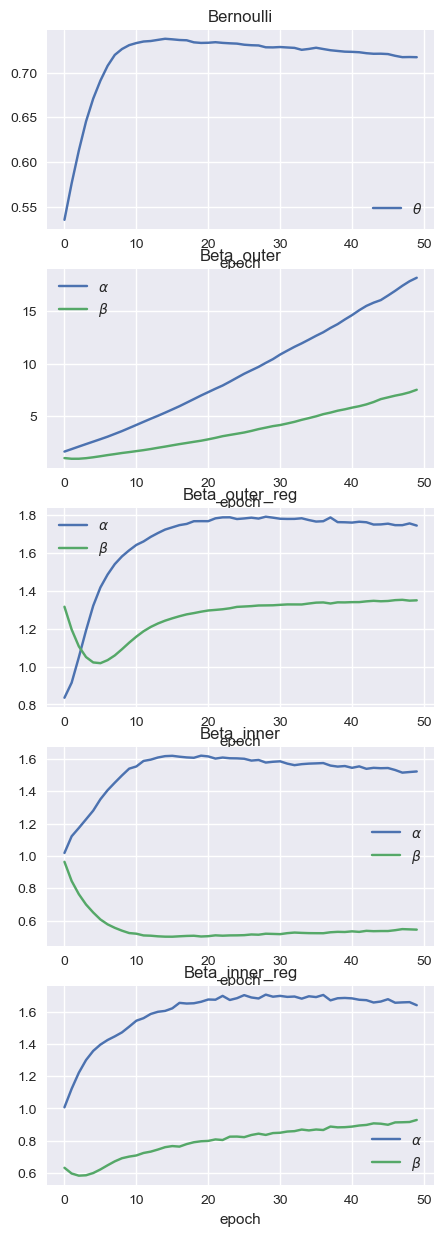

In [53]:
plot_mean_params(loaded_dict)

In [6]:
dataset = BernoulliSineDataset
dataset_eval = dataset(**data_config["classification"])
x_eval = torch.from_numpy(np.linspace(0, 1,1000)).float()
y_eval = sine_fct_prediction(x_eval, freq=data_config["classification"]["sine_factor"])
x_train = dataset_eval.x_inst
y_targets = dataset_eval.y_labels

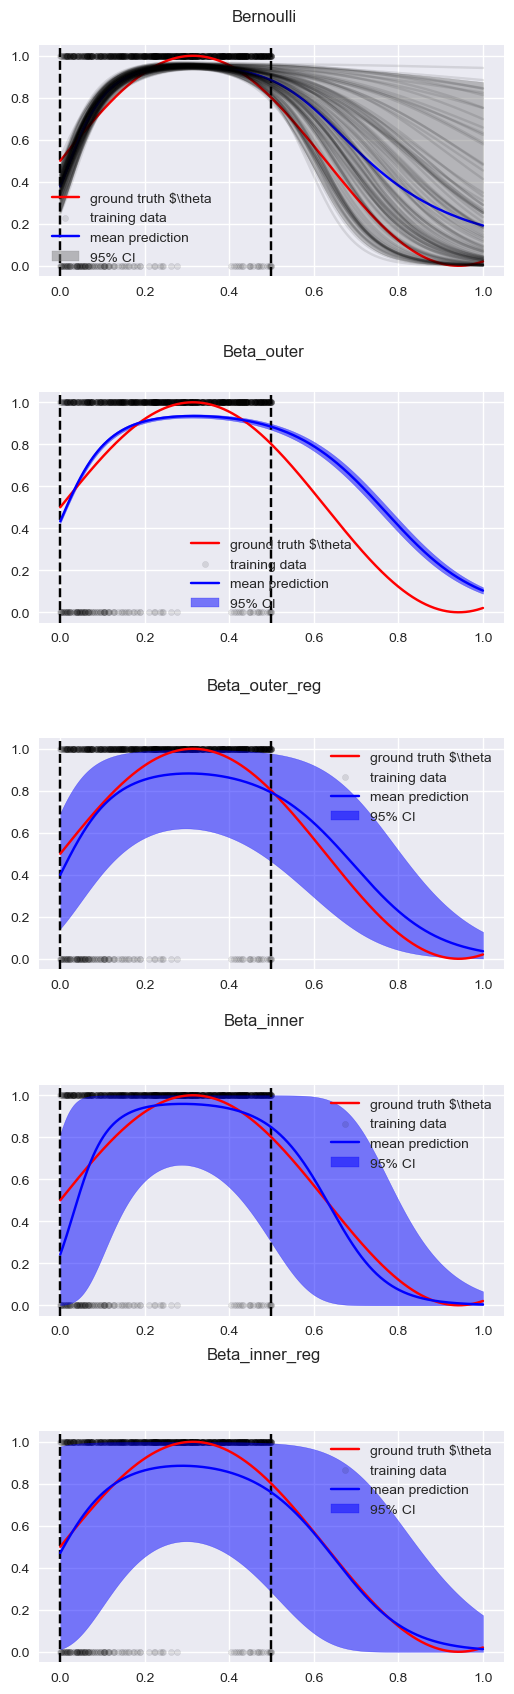

In [10]:
fig, ax = plot_bernoulli_beta_prediction_intervals(
            results_dict=loaded_dict,
            x_train=x_train, x_eval=x_eval,
            y_targets=y_targets, y_eval=y_eval)

# save figure
fig.savefig("results_confidence_bounds_classification.png", dpi=300, bbox_inches="tight")

In [9]:
plt.savefig("results_confidence_bounds_classification.png")

<Figure size 800x550 with 0 Axes>

In [3]:
exp_name = "exp2"
# check if file name exp_name already exists in dir results
if not os.path.exists("results/" + exp_name):
    os.makedirs("results/" + exp_name)

In [4]:
# generate a string that contains the date and time
import datetime

now = datetime.datetime.now()
date_time = now.strftime("%Y-%m-%d-%H-%M-%S")
date_time

'2024-01-09-14-45-25'

In [5]:
dataset_eval = PolynomialDataset(**data_config["regression"])

In [6]:
x_eval = torch.from_numpy(np.linspace(-6,6,100)).float()
y_eval = polynomial_fct(x_eval, degree=3)
x_inst = dataset_eval.x_inst
y_targets = dataset_eval.y_targets

In [20]:
LAMBDA_REG = 1.0 # weight of regularization term
N_EPOCHS = 1000
LR = 0.0005
BATCH_SIZE = 128
REG_TYPE = "evidence"
ENSEMBLE_SIZE = 100 # "evidence" or "entropy" or "kl"

temp_dict = {'LAMBDA_REG': LAMBDA_REG, 'N_EPOCHS': N_EPOCHS, 'LR': LR, 'BATCH_SIZE': BATCH_SIZE, 'REG_TYPE': REG_TYPE, 'ENSEMBLE_SIZE': ENSEMBLE_SIZE}
# create a json file with the LAMBDA_REG, N_EPOCHS, LR, BATCH_SIZE, REG_TYPE, ENSEMBLE_SIZE and save it in the exp_name folder
with open("results/"+exp_name+"/sample.json", "w") as outfile: 
    json.dump(temp_dict, outfile)

In [21]:
# load json file located in the config_dir directory into a dictionary
with open("results/"+exp_name+"/sample.json") as json_file: 
    data = json.load(json_file)

In [22]:

train_config = create_train_config(type="regression", n_epochs=N_EPOCHS, lr=LR,
                                    batch_size=BATCH_SIZE, reg_type=REG_TYPE, lambda_reg=LAMBDA_REG)


In [10]:
train_config

{'Normal': {'model': epuc.models.RegressorModel,
  'loss': NegativeLogLikelihoodLoss(),
  'n_epochs': 500,
  'optim': torch.optim.adam.Adam,
  'optim_kwargs': {'lr': 0.001},
  'batch_size': 128,
  'ensemble_size': 100},
 'NIG_outer': {'model': epuc.models.NIGNN,
  'loss': outer_loss_der(),
  'n_epochs': 500,
  'optim': torch.optim.adam.Adam,
  'optim_kwargs': {'lr': 0.001},
  'batch_size': 128,
  'ensemble_size': 1},
 'NIG_outer_reg': {'model': epuc.models.NIGNN,
  'loss': outer_loss_der(),
  'n_epochs': 500,
  'optim': torch.optim.adam.Adam,
  'optim_kwargs': {'lr': 0.001},
  'batch_size': 128,
  'ensemble_size': 1},
 'NIG_inner': {'model': epuc.models.NIGNN,
  'loss': inner_loss_der(),
  'n_epochs': 500,
  'optim': torch.optim.adam.Adam,
  'optim_kwargs': {'lr': 0.001},
  'batch_size': 128,
  'ensemble_size': 1},
 'NIG_inner_reg': {'model': epuc.models.NIGNN,
  'loss': inner_loss_der(),
  'n_epochs': 500,
  'optim': torch.optim.adam.Adam,
  'optim_kwargs': {'lr': 0.001},
  'batch_siz

In [23]:
results_per_ens_dict = {}
for ens_type in train_config.keys():
    results_per_ens_dict[ens_type] = {}
    if ens_type == "Normal":
        ensemble = GaussianEnsemble(
            model_config=model_config["Normal"], ensemble_size=ENSEMBLE_SIZE
        )

    else:
        ensemble = NIGEnsemble(
            model_config=model_config["NormalInverseGamma"], ensemble_size=1
        )

    ensemble.train(
        dataset=PolynomialDataset,
        data_params=data_config["regression"],
        train_params=train_config[ens_type],
    )

    preds = ensemble.predict(x_eval.view(-1, 1)).detach().numpy()
    print(preds.shape)

    # get mean and standard deviation of both mu and sigma predictions TODO: will probably need to be customized!
    mean_params = ensemble.predict_mean(x_eval.view(-1, 1))

    # results_per_ens_dict[ens_type]["mean_params"] = mean_params
    # results_per_ens_dict[ens_type]["std_params"] = std_params

    if ens_type == "Normal":
        std_params = ensemble.predict_std(x_eval.view(-1, 1))

        results_per_ens_dict[ens_type]["mean_mus"] = mean_params[:, 0]
        results_per_ens_dict[ens_type]["mean_sigmas"] = mean_params[:, 1]
        results_per_ens_dict[ens_type]["pred_mus"] = preds[:, :, 0]
        results_per_ens_dict[ens_type]["pred_sigmas"] = preds[:, :, 1]

        # confidence bounds
        lower_mu, upper_mu = get_upper_lower_bounds_normal(
            p=0.975,
            mu=mean_params[:, 0].detach().numpy(),
            sigma=std_params[:, 0].detach().numpy(),
        )
        lower_sigma2, upper_sigma2 = get_upper_lower_bounds_empirical(
            p=0.975,
            y=preds[:, :, 1]**2, # take square of sigma
        )

        results_per_ens_dict[ens_type]["lower_mu"] = lower_mu
        results_per_ens_dict[ens_type]["upper_mu"] = upper_mu
        results_per_ens_dict[ens_type]["lower_sigma"] = lower_sigma2
        results_per_ens_dict[ens_type]["upper_sigma"] = upper_sigma2

    else:
        mean_mu, var_mu, mean_sigma2, var_sigma2 = ensemble.predict_normal_params(
            x_eval.view(-1, 1)
        )

        results_per_ens_dict[ens_type]["pred_gammas"] = preds[:, :, 0]
        results_per_ens_dict[ens_type]["pred_nus"] = preds[:, :, 1]
        results_per_ens_dict[ens_type]["pred_alphas"] = preds[:, :, 2]
        results_per_ens_dict[ens_type]["pred_betas"] = preds[:, :, 3]

        results_per_ens_dict[ens_type]["mean_pred_mu"] = mean_mu
        results_per_ens_dict[ens_type]["mean_pred_sigma2"] = mean_sigma2

        # confidence bounds
        lower_mu, upper_mu = get_upper_lower_bounds_normal(
                p=0.975,
                mu=mean_mu.detach().numpy(),
                sigma=np.sqrt(var_mu.detach().numpy()),
            )
        
        lower_sigma2, upper_sigma2 = get_upper_lower_bounds_inv_gamma(
            p=0.975,
            alpha=mean_params[:, 2].detach().numpy(),
            beta=mean_params[:, 3].detach().numpy(),
        )

        results_per_ens_dict[ens_type]["lower_mu"] = lower_mu
        results_per_ens_dict[ens_type]["upper_mu"] = upper_mu
        results_per_ens_dict[ens_type]["lower_sigma"] = lower_sigma2
        results_per_ens_dict[ens_type]["upper_sigma"] = upper_sigma2

100%|██████████| 100/100 [10:39<00:00,  6.39s/it]


(100, 100, 2)


100%|██████████| 1/1 [00:07<00:00,  7.91s/it]


(100, 1, 4)


100%|██████████| 1/1 [00:08<00:00,  8.23s/it]


(100, 1, 4)


100%|██████████| 1/1 [00:08<00:00,  8.52s/it]


(100, 1, 4)


100%|██████████| 1/1 [00:08<00:00,  8.85s/it]

(100, 1, 4)


In [ ]:
# save a dictionary into a pkl file
import pickle

with open("results/"+exp_name+"/results_per_ens_dict.pkl", "wb") as f:
    pickle.dump(results_per_ens_dict, f)

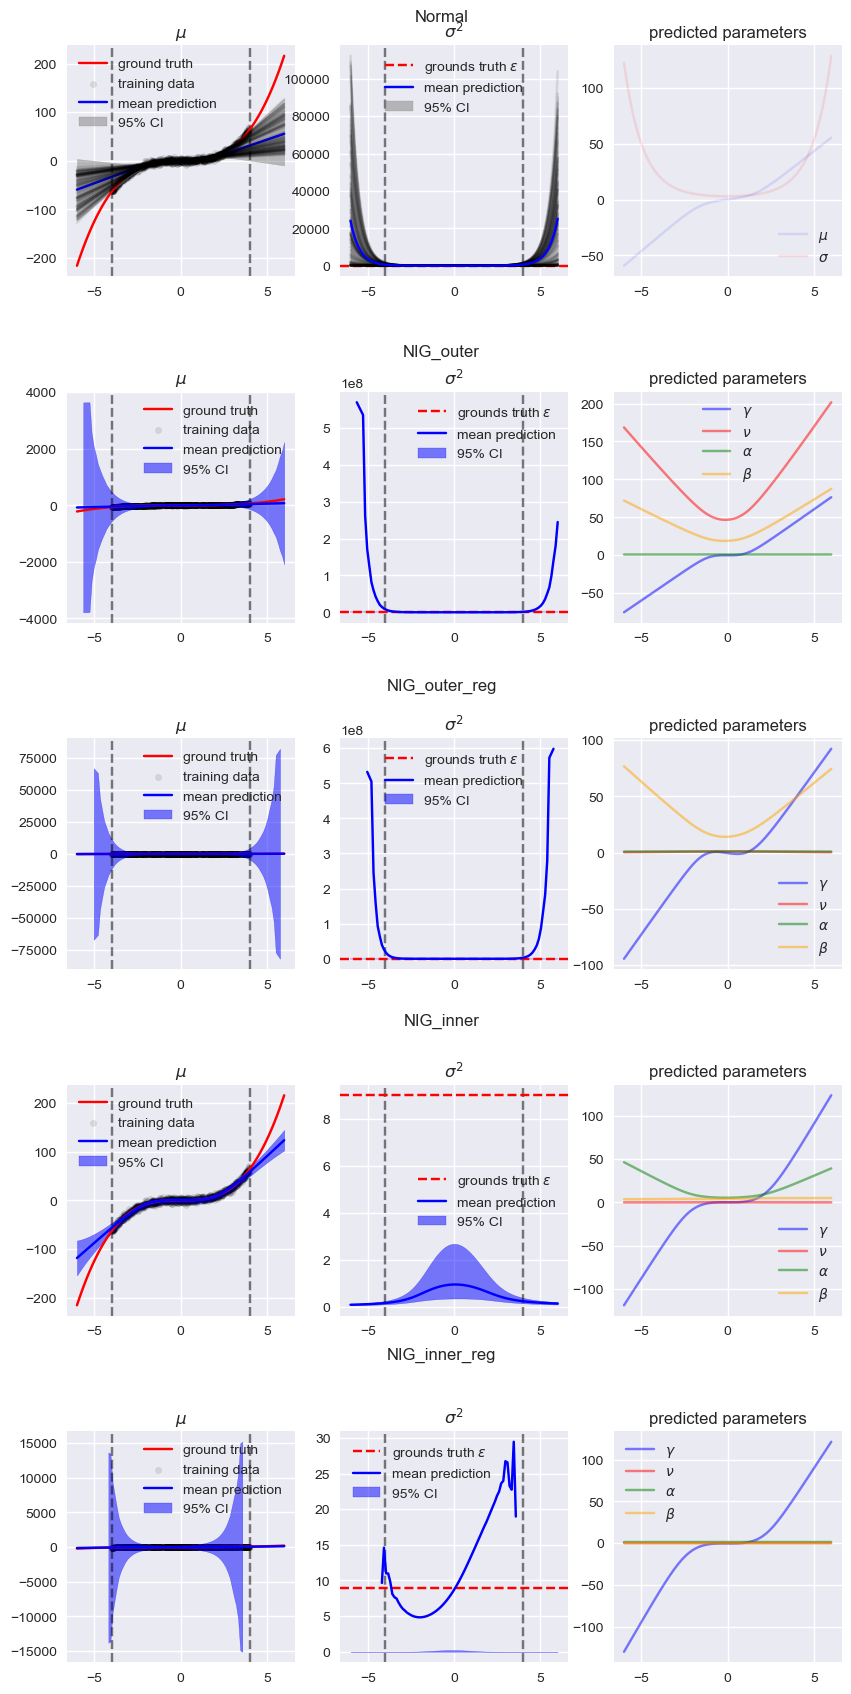

In [54]:
std = dataset_eval.eps_std

fig, ax = plt.subplots(len(results_per_ens_dict), 3, figsize=(10, 21))
for i, ens_type in enumerate(results_per_ens_dict.keys()):
    fig.text(
        0.5,
        ax[i, 0].get_position().bounds[1] + ax[i, 0].get_position().height + 0.01,
        f"{ens_type}",
        ha="center",
        va="bottom",
        fontsize="large",
    )
    # plot dotted vertical lines for minimum and maximum of training data
    ax[i, 0].axvline(x_inst.min(), linestyle="--", color="black", alpha=0.5)
    ax[i, 0].axvline(x_inst.max(), linestyle="--", color="black", alpha=0.5)
    ax[i, 1].axvline(x_inst.min(), linestyle="--", color="black", alpha=0.5)
    ax[i, 1].axvline(x_inst.max(), linestyle="--", color="black", alpha=0.5)
    ax[i, 0].set_title("$\mu$")
    ax[i, 1].set_title("$\sigma^2$")
    ax[i, 2].set_title("predicted parameters")
    ax[i, 0].plot()
    ax[i, 0].plot(x_eval, y_eval, label="ground truth", color="red")
    # plot horizontal dotted line at std**3
    ax[i, 1].axhline(std**2, linestyle="--", color="red", label="grounds truth $\epsilon$")
    # plot training data
    ax[i, 0].scatter(
            x_inst,
            y_targets,
            label="training data",
            marker="o",
            s=20,
            color="black",
            alpha=0.1,
        )
    if ens_type == "Normal":
        # plot predictions for mu ------------------------------------
        ax[i, 0].plot(
            x_eval,
            results_per_ens_dict[ens_type]["mean_mus"].detach().numpy(),
            label="mean prediction",
            color="blue",
        )
        ax[i, 0].plot(
            x_eval, results_per_ens_dict[ens_type]["pred_mus"], alpha=0.1, color="black"
        )
        ax[i, 0].fill_between(
            x_eval,
            results_per_ens_dict[ens_type]["lower_mu"],
            results_per_ens_dict[ens_type]["upper_mu"],
            alpha=0.5,
            label="95% CI",
            color="gray",
        )
        ax[i, 0].legend()
        # ------------------------------------
        # plot predictions for sigma
        ax[i, 1].plot(
            x_eval,
            results_per_ens_dict[ens_type]["pred_sigmas"]**2,
            alpha=0.1,
            color="black",
        )
        ax[i, 1].plot(
            x_eval,
            np.mean((results_per_ens_dict[ens_type]["pred_sigmas"]**2), axis=1),
            label="mean prediction",
            color="blue",
        )
        ax[i, 1].fill_between(
            x_eval,
            results_per_ens_dict[ens_type]["lower_sigma"],
            results_per_ens_dict[ens_type]["upper_sigma"],
            alpha=0.5,
            label="95% CI",
            color="gray",
        )
        ax[i, 1].legend()
        # ------------------------------------
        # lpot predicted parameters of the normal distribution
        ax[i, 2].plot(
            x_eval,
            results_per_ens_dict[ens_type]["mean_mus"].detach().numpy(),            alpha=0.1,
            color="blue", label="$\mu$",
        )
        ax[i, 2].plot(
            x_eval,
            np.mean(results_per_ens_dict[ens_type]["pred_sigmas"], axis=1),
            alpha=0.1,
            color="red", label="$\sigma$",
        )
        ax[i,2].legend()

    else:
        # plot predictions for mu ------------------------------------
        ax[i, 0].plot(
            x_eval,
            results_per_ens_dict[ens_type]["mean_pred_mu"].detach().numpy(),
            label="mean prediction",
            color="blue",
        )
        ax[i, 0].fill_between(
            x_eval,
            results_per_ens_dict[ens_type]["lower_mu"],
            results_per_ens_dict[ens_type]["upper_mu"],
            alpha=0.5,
            label="95% CI",
            color="blue",
        )
        
        ax[i, 0].legend()
        # ------------------------------------
        # plot predictions for sigma ------------------------------------
        ax[i, 1].plot(
            x_eval,
            results_per_ens_dict[ens_type]["mean_pred_sigma2"].detach(),
            label="mean prediction", color="blue",
        )
        ax[i, 1].fill_between(
            x_eval,
            results_per_ens_dict[ens_type]["lower_sigma"],
            results_per_ens_dict[ens_type]["upper_sigma"],
            alpha=0.5,
            label="95% CI",
            color="blue",
        )
        ax[i, 1].legend()
        # ------------------------------------
        # plot predicted parameters of the normal-inverse-gamma distribution
        ax[i, 2].plot(
            x_eval,
            np.mean(results_per_ens_dict[ens_type]["pred_gammas"], axis=1),
            alpha=0.5,
            color="blue", label=r"$\gamma$",
        )
        ax[i, 2].plot(
            x_eval,
            np.mean(results_per_ens_dict[ens_type]["pred_nus"], axis=1),
            alpha=0.5,
            color="red", label=r"$\nu$",
        )
        ax[i, 2].plot(
            x_eval,
            np.mean(results_per_ens_dict[ens_type]["pred_alphas"], axis=1),
            alpha=0.5,
            color="green", label=r"$\alpha$",
        )
        ax[i, 2].plot(
            x_eval,
            np.mean(results_per_ens_dict[ens_type]["pred_betas"], axis=1),
            alpha=0.5,
            color="orange", label=r"$\beta$",
        )

        ax[i, 2].legend()
        

fig.subplots_adjust(hspace=0.5)
#plt.tight_layout()
# save figure
plt.savefig("results/"+exp_name+"/fig.png")


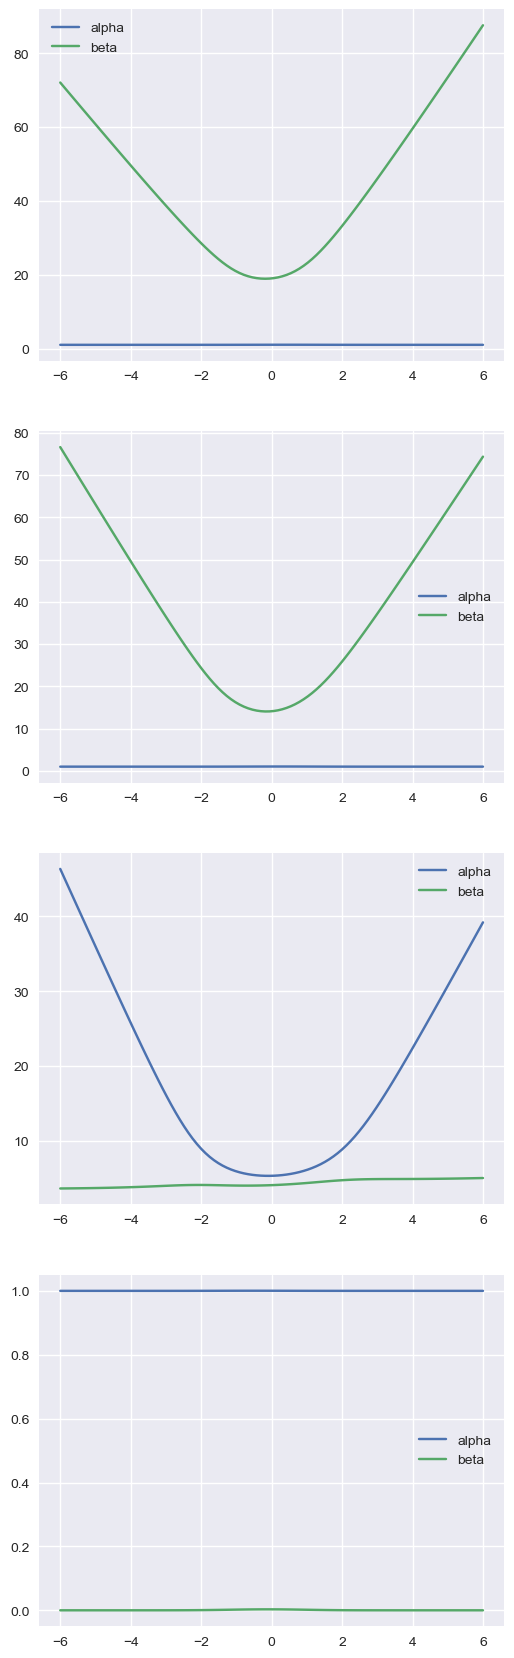

In [31]:
fig, ax = plt.subplots(len(results_per_ens_dict) - 1, 1, figsize=(6, 21))
for i, ens_type in enumerate(list(results_per_ens_dict.keys())[1:]):
    pred_alpha = results_per_ens_dict[ens_type]["pred_alphas"].squeeze()
    pred_beta = results_per_ens_dict[ens_type]["pred_betas"].squeeze()

    # plot alpha and beta per eval point
    ax[i].plot(x_eval, pred_alpha, label="alpha")
    ax[i].plot(x_eval, pred_beta, label="beta")
    ax[i].legend()


In [29]:
list(results_per_ens_dict.keys())

['Normal', 'NIG_outer', 'NIG_outer_reg', 'NIG_inner', 'NIG_inner_reg']

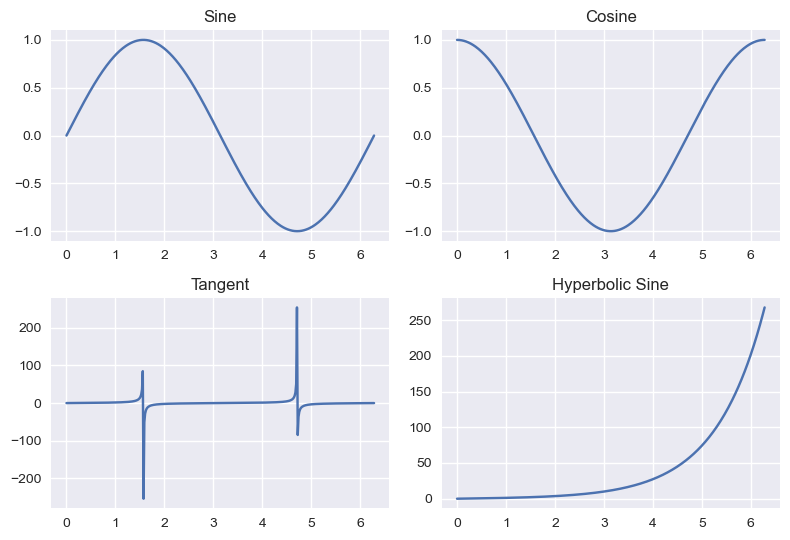

In [16]:
fig, axs = plt.subplots(2, 2)

# Generate some data
x = np.linspace(0, 2 * np.pi, 400)

# Plot different functions in each subplot
axs[0, 0].plot(x, np.sin(x))  # top left
axs[0, 1].plot(x, np.cos(x))  # top right
axs[1, 0].plot(x, np.tan(x))  # bottom left
axs[1, 1].plot(x, np.sinh(x))  # bottom right

# Set titles for each subplot
axs[0, 0].set_title('Sine')
axs[0, 1].set_title('Cosine')
axs[1, 0].set_title('Tangent')
axs[1, 1].set_title('Hyperbolic Sine')

# Display the plot
plt.tight_layout()
plt.show()

In [18]:
len(results_per_ens_dict)

5

In [75]:
# iterate over the different folders in the results folder and extract the json file from each one
os.listdir("results")

['exp1', 'exp1 copy', 'exp2']

In [ ]:
LAMBDA_REG = 1.0


In [77]:
for exp_name in os.listdir("results"):
    with open("results/" + exp_name + "/sample.json") as json_file:
        data = json.load(json_file)
        if data['LAMBDA_REG'] == LAMBDA_REG:
            print(exp_name)

exp1
exp1 copy
exp2
